* **Original paper:** [*Tessa C, Lucetti C, Giannelli M, Diciotti S, Poletti M, Danti S, Baldacci F, Vignali C, Bonuccelli U, Mascalchi M, Toschi N. Progression of brain atrophy in the early stages of Parkinson's disease: a longitudinal tensor-based morphometry study in de novo patients without cognitive impairment. Hum Brain Mapp. 2014 Aug;35(8):3932-44. doi: 10.1002/hbm.22449. Epub 2014 Jan 22. PMID: 24453162; PMCID: PMC6868950.*](https://onlinelibrary.wiley.com/doi/abs/10.1002/hbm.22449)

# Introduction

* **Cohort quote from the paper:** "*Overall, 22 patients (4 women and 18 men, mean age 61.5 ± 8.8) and 17 control subjects (8 women and 9 men, mean age 59.1 ± 8.5 years) completed the study and underwent a second MRI examination. The mean (± standard deviation) follow-up time for patients and controls was 2.8 ± 0.6 (range 2–4) years and 3.9 ± 2.2 (range 2–7) years, respectively. Differences for age between PD patients and control subjects were not significant (P = 0.48, MannWhitney U-test)*"


* Demographics for the PD patients (table taken from the paper):
<img src="./images/original-cohort.png" alt= “” width="30%" height="30%">


* At the baseline evaluation "*No difference in local volume between patients and control subjects was revealed*".


* A (very) brief summary of the main results of the logtitudinal evaluation is:


  * Control subjects: Baseline versus follow-up
    * Control subjects experienced atrophy in several white matter and grey matter regions (Fig. 1a), and cerebrospinal fluid enlargement. There were atrophy clusters involved mainly in white matter, and were more widespread in the frontal lobe.
    
    
  * PD patients: Baseline versus follow-up
    * PD patients showed clusters of reduced white and grey matter volume. These were more evident in the white matter, specially the frontal lobe (Fig. 1b), and showed cerebrospinal fluid enlargement. Grey matter involvement was more widespread than in the control subjects.
    <img src="./images/original-fig1.png" alt= “” width="50%" height="50%">
    
  * PD patients versus control subjects
    * "*PD patients developed bilateral clusters of increased atrophy*" (Fig. 2).
    <img src="./images/original-fig2.png" alt= “” width="50%" height="50%">
    
    
  * Correlation analyses
    * "*In PD patients, no significant correlation between warprates and motor or neuropsychological test scores or their average changes per year between baseline and follow-up were identified*".

# Setup

In [1]:
import os
import subprocess
import random
import shutil
import logging
import nibabel as nib
import numpy as np
import pandas as pd
import csv
import glob
import re

from datetime import datetime
import statistics
from scipy.stats import mannwhitneyu

import livingpark_utils
from livingpark_utils import download
from livingpark_utils import clinical
from livingpark_utils.scripts import run
from livingpark_utils.scripts import mri_metadata
from nilearn import plotting

This notebook was run on 2024-07-25 06:41:37 UTC +0000
['COR', 'Coronal', 'Cal Head 24', 'Transverse', 'tra_T1_MPRAGE', 'TRA']
['AX', 'Ax', 'axial', 'Phantom', 'T2']
{'Screening': 'SC', 'Baseline': 'BL', 'Month 6': 'V02', 'Month 12': 'V04', 'Month 24': 'V06', 'Month 36': 'V08', 'Month 48': 'V10', 'Symptomatic Therapy': 'ST', 'Unscheduled Visit 01': 'U01', 'Unscheduled Visit 02': 'U02', 'Premature Withdrawal': 'PW'}
Saved in MRI_info.csv


In [2]:
# Notebook data initialization
inputs_dir = os.path.join(os.getcwd(), "inputs/study_files")
outputs_dir = os.path.join(os.getcwd(), "outputs")
data_dir = os.path.join(os.getcwd(), "data")

utils = livingpark_utils.LivingParkUtils()
# downloader = downlo.Downloader(utils.study_files_dir)
#random_seed = 1
utils.notebook_init()

This notebook was run on 2024-07-25 06:42:24 UTC +0000


# PPMI Cohort Data Acquisition

In [3]:
# PPMI study data files to reconstruct cohort and demographics table

required_files = [
    "Demographics.csv",                                   # Sex
    "Age_at_visit.csv",                                   # Age
    "Montreal_Cognitive_Assessment__MoCA_.csv",           # MMSE
    "PD_Diagnosis_History.csv",                           # Disease duration
    "Cognitive_Categorization.csv",                       # MCI diagnosis
    "Participant_Status.csv",                             # Parkinson's vs healthy diagnosis
    "Primary_Clinical_Diagnosis.csv",                     # Subjects with no PD nor other neurological disorder
    "Geriatric_Depression_Scale__Short_Version_.csv",     # GDSS - depression screening
    "Family_History.csv",                                 # PD familial history
    "General_Physical_Exam.csv",                          # Cardio-vascular dysfunction (exclusion)
    "Magnetic_Resonance_Imaging__MRI_.csv",               # Baseline & ~24 month follow-up T1w images
    #"MDS_UPDRS_Part_II__Patient_Questionnaire.csv",      # UPDRS II
    "MDS-UPDRS_Part_III.csv",                             # UPDRS III, and Hoehn and Yahr scores
    "Medical_Conditions_Log.csv"                          # Depression diagnosis (and other neuro/psych conditions)
]

utils.download_ppmi_metadata(required_files, headless=False)

/tmp/ipykernel_1224966/351944342.py:20: DeprecationWarning: Call to deprecated function download_ppmi_metadata.
This function will be remove in future version.
Moved to function `livinpark_utils::LivingParkUtils::get_study_files`.
  utils.download_ppmi_metadata(required_files, headless=False)
/lustre04/scratch/jacobsr/lp_final/venv_new/lib/python3.11/site-packages/traits/observation/_generated_parser.py:258: DeprecationWarning: module 'sre_parse' is deprecated
  import sre_parse
/lustre04/scratch/jacobsr/lp_final/venv_new/lib/python3.11/site-packages/traits/observation/_generated_parser.py:259: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


Download skipped: No missing files!


In [4]:
# Reading in all the demographic info files for the relevant variables

# Age
age_df = pd.read_csv(os.path.join(inputs_dir, "Age_at_visit.csv"), usecols=["PATNO", "EVENT_ID", "AGE_AT_VISIT"])


# Sex
sex_df = pd.read_csv(os.path.join(inputs_dir,"Demographics.csv"), usecols=["PATNO", "SEX"])


# Diagnosis
diagnosis_df = pd.read_csv(os.path.join(inputs_dir, "Primary_Clinical_Diagnosis.csv"), usecols=["PATNO", "EVENT_ID", "PRIMDIAG"])


# Disease duration
disease_duration_df = pd.read_csv(os.path.join(inputs_dir,"PD_Diagnosis_History.csv"), usecols=["PATNO", "EVENT_ID", "PDDXDT"])
disease_duration_df = disease_duration_df.drop(["EVENT_ID"], axis=1) 


# Cognitive categorization (MCI/Dementia/Healthy)
cog_cat_df = pd.read_csv(os.path.join(inputs_dir, "Cognitive_Categorization.csv"), usecols=["PATNO", "EVENT_ID", "COGSTATE"])


# UPDRS3 and HY
updrs3_df = pd.read_csv(os.path.join(inputs_dir,"MDS-UPDRS_Part_III.csv"), usecols=["PATNO", "EVENT_ID", "NP3TOT", "NHY"])


# Medical condition (Depression)
med_cond_df = pd.read_csv(os.path.join(inputs_dir, "Medical_Conditions_Log.csv"), usecols=["PATNO", "EVENT_ID", "MHCAT"]).groupby(['PATNO', 'EVENT_ID'])[['MHCAT']].aggregate(lambda x: tuple(set(x))) # aggregate all codes in a tuple
dep = []
for x in med_cond_df['MHCAT']:
    if 115 in x: #115 = depression
        dep.append(1)
    else:
        dep.append(0)     
new_med = med_cond_df
new_med['Depression'] = dep
new_med = new_med.reset_index()
new_med = new_med.drop(["EVENT_ID", "MHCAT"], axis=1) 


# MoCA --> MMSE
moca_df = pd.read_csv(os.path.join(inputs_dir,"Montreal_Cognitive_Assessment__MoCA_.csv"), usecols=["PATNO", "EVENT_ID", "MCATOT"])
moca_df["MMSETOT"] = moca_df["MCATOT"].apply(clinical.moca2mmse)


# Parkinson's (COHORT=1) vs healthy control (COHORT=2)
part_stat_df = pd.read_csv(os.path.join(inputs_dir, "Participant_Status.csv"), usecols=["PATNO", "COHORT"])


# GDSS
gdsshort_df = pd.read_csv(os.path.join(inputs_dir,"Geriatric_Depression_Scale__Short_Version_.csv"))
gdsshort_df = gdsshort_df.drop(["REC_ID","PAG_NAME", "INFODT","ORIG_ENTRY","LAST_UPDATE"], axis=1)
gds = gdsshort_df.iloc[:, 2:] # Calculate GDS score for each patient
gds = gds.agg(['sum'], axis="columns").rename(columns={"sum": "GDSTOT"})
gdsshort_df = pd.concat([gdsshort_df[['PATNO', 'EVENT_ID']], gds], axis=1) #Add gds score to df


# Physical Examination (For now just need PESEQ=6 for cardiovascular...Might need neurological too?)
physical_df = pd.read_csv(os.path.join(inputs_dir, "General_Physical_Exam.csv"), usecols=["PATNO", "PESEQ", "ABNORM"])
physical_df_mod = physical_df.loc[(physical_df['PESEQ'] == 6)]
physical_df_mod = physical_df_mod.drop('PESEQ', axis=1)

# MRI availability
run.mri_metadata()
mri_df = pd.read_csv(os.path.join(inputs_dir,"MRI_info.csv"))
mri_df["EVENT_ID"] = mri_df["Visit code"]
mri_df["PATNO"] = mri_df["Subject ID"]
mri_df["Sex"] = mri_df["Sex"].map({"F": 0, "M": 1})
mri_df = mri_df.drop(["Subject ID", "Visit code", "Visit", "Age", "Sex", "Imaging Protocol"], axis=1)

0.0


# Data aggregation

In [5]:
# Merging all of the relevant study file variables into one big dataframe

result = pd.merge(age_df, sex_df, on=["PATNO"], how="outer")
result = pd.merge(result, part_stat_df, on=["PATNO"], how="outer")
result = pd.merge(result, diagnosis_df, on=["PATNO", "EVENT_ID"], how="outer")
result = pd.merge(result, cog_cat_df, on=["PATNO", "EVENT_ID"], how="outer")
result = pd.merge(result, updrs3_df, on=["PATNO", "EVENT_ID"], how="outer")
result = pd.merge(result, moca_df, on=["PATNO", "EVENT_ID"], how="outer")
result = pd.merge(result, gdsshort_df, on=["PATNO", "EVENT_ID"], how="outer")
result = pd.merge(result, physical_df_mod, on=["PATNO"], how="outer")
result = pd.merge(result, new_med, on=["PATNO"], how="outer") 
result = pd.merge(result, disease_duration_df, on=["PATNO"], how="outer")
result = pd.merge(result, mri_df, on=["PATNO", "EVENT_ID"], how="outer")

# Cohort Matching

We now attempt to reconstruct a cohort which is as similar to the original study as possible using the PPMI data.

* ### Inclusion/Exclusion criteria I will use to replicate this study:


  * Baseline and ~36 month follow-up T1-weighted MRIs available and usable for TBM. (MRI_info.csv: **Study Date**)
  
  
  * Disease duration ~1 year at baseline (PD_Diagnosis_History.csv: **PDDXDT**).
  
  
  * No MCI or dementia (Cognitive_Categorization.csv: **COGSTATE** != 3 for dementia, 2 for MCI)
  
  
  * No depression (Medical_Conditions_Log.csv: **MHCAT** != 115 --> **Depression** != 1 in aggregation )
  
  
  * No cardio-vascular autonomic dysfunction (General_Physical_Exam.csv: **PESAQ** == 6 && **ABNORM** == 0 --> **ABNORM** != 1 in aggregation)
  
  
  * Subjects: 4 PD women and 18 PD men (Participant_Status.csv: **COHORT**==1 PD)
  * Controls: 8 HC women and 9 HC men (Participant_Status.csv: **COHORT**==2 HC)
  * Demographics.csv: **SEX**==1 Male, **SEX**==0 Female
  
  
  * Controls: a normal neurological examination (Unsure: Primary_Clinical_Diagnosis.csv: **PRIMDIAG==17**, Or Neurological_exam.csv battery, or just Participant_Status.csv: **COHORT**==2?), and no relatives with PD (*See the notes below on how this differs from the original study*).
  
* ### Replication Limitations, and other points to consider


  * For the control subjects, the original study states that they must have "No history of familial or personal neurological diseases". I can't find this detailed familial data in PPMI, the existing familial data is only with regard to PD.
  
  
  * We are using the PPMI's cognitive state diagnosis for MCI instead of the original paper's battery of standardized neuropsychological tests.
  
  
  * While it's not an inclusion/exclusion criterion, the paper states that  "At follow-up examination, all patients were receiving L-dopa". It makes no mention of L-dopa at baseline.
  
  * There are not enough female healthy controls in PPMI that meet our criteria, so we are using 6 female controls instead of 8, and using 11 men instead of 9.

In [6]:
#PD Subjects query

# ~36 month followup, range 24-48 months within ~1yr of diagnoses (needs EVENT_ID = BL)
visit2month = {"V06": 24, "V10": 48} # Visits with MRI scans

#Initial filtering for inclusion/exclusion criteria
PD_query = result.loc[(result['ABNORM'] == 0.0) &
           (result['COGSTATE'] != 2.0) & 
           (result['COGSTATE'] != 3.0) &
           (result['Depression'] != 1.0) &
           (result['Study Date'].notnull()) &
           (result['COHORT'] == 1.0)] #Need PRIMDIAG == 1, but doesn't seem necessary upon inspecting 'result'.

PATNO_list = PD_query["PATNO"].unique() #Get unique python list of PATNOs to iterate over.
events = visit2month.keys() #Get list of Event_IDs to form combinations
PD_followup = pd.DataFrame(columns=PD_query.columns.values.tolist()) #empty dataframe to store followup queries

#Make a dataframe containing a single entry for the BL, and followup EVENT_IDs
for PATNO_curr in PATNO_list: #iterate over all patients, check if desired EVENT_ID combination exists
        PD_temp = pd.DataFrame(columns=PD_query.columns.values.tolist())
        event1 = PD_query.loc[(PD_query['PATNO'] == PATNO_curr) & (PD_query['EVENT_ID'] == 'BL')] #Baseline
        PD_temp = pd.concat([PD_temp, event1])
        for c in events: #Iterate over followup EVENT_IDs
            event2 = PD_query.loc[(PD_query['PATNO'] == PATNO_curr) & (PD_query['EVENT_ID'] == c)] #Followups
            PD_temp = pd.concat([PD_temp, event2])
            if (event1.empty == False and event2.empty == False): # follow up exists
                PD_followup = pd.concat([PD_followup, PD_temp])

#Drop duplicate entries for same Event_ID within a patient
PD_followup = PD_followup.drop_duplicates(subset=['PATNO', 'EVENT_ID'], keep="first")                

#Randomly choose 18 males, 4 females at Baseline
PD_cohort_M = PD_followup.loc[(PD_followup['SEX'] == 1.0) & 
                              (PD_followup['EVENT_ID'] == "BL")].sample(n=18, random_state=5)
PD_cohort_F = PD_followup.loc[(PD_followup['SEX'] == 0.0) &
                              (PD_followup['EVENT_ID'] == "BL")].sample(n=4, random_state=5)
PD_cohort_final = pd.concat([PD_cohort_M, PD_cohort_F])

#Append followup event to final cohort: first try v06, then v10
used_PATNO_list = []
final_PATNO_list = PD_cohort_final["PATNO"].unique()
for PATNO_curr in final_PATNO_list:
    followup = PD_followup.loc[(PD_followup['PATNO'] == PATNO_curr) & (PD_followup['EVENT_ID'] == "V06")]
    PD_cohort_final = pd.concat([PD_cohort_final, followup])
    if followup.empty == False:
        used_PATNO_list.append(PATNO_curr)
    #if(len(used_PATNO_list) >= 13): #Gets us closest to the 2.8yr follow-up average with range 2-4yrs
    #    break    #We sadly can't do this as we don't have enough subjects
not_used_PATNO_list = list(set(final_PATNO_list) - set(used_PATNO_list))
for PATNO_curr in not_used_PATNO_list: #Use some V10 visits too
    followup = PD_followup.loc[(PD_followup['PATNO'] == PATNO_curr) & (PD_followup['EVENT_ID'] == "V10")]
    PD_cohort_final = pd.concat([PD_cohort_final, followup])

#display(PD_cohort_final.sort_values(['PATNO', 'EVENT_ID']))
print("Number of scans in PD cohort: " + str(len(PD_cohort_final.index)))

Number of scans in PD cohort: 44


In [7]:
#Control Group query

# ~47 month followup, range 24-84 months within ~1yr of diagnoses (needs EVENT_ID = BL)
visit2month = {"V06": 24, "V10": 48} # Visits with MRI scans

#Initial filtering for inclusion/exclusion criteria
HC_query = result.loc[(result['ABNORM'] == 0.0) &
           (result['COGSTATE'] != 2.0) & 
           (result['COGSTATE'] != 3.0) &
           (result['Depression'] != 1.0) &
           (result['Study Date'].notnull()) &
           (result['COHORT'] == 2.0)] #Need PRIMDIAG == 17, but seems unnecessary upon inspecting 'results'

PATNO_list_HC = HC_query["PATNO"].unique() #Get unique python list of PATNOs to iterate over.
events = visit2month.keys() #Get list of Event_IDs to form combinations
HC_followup = pd.DataFrame(columns=HC_query.columns.values.tolist()) #empty dataframe to store followup queries

for PATNO_curr in PATNO_list_HC: #iterate over all controls, check if desired EVENT_ID combination exists
        HC_temp = pd.DataFrame(columns=HC_query.columns.values.tolist())
        event1 = HC_query.loc[(HC_query['PATNO'] == PATNO_curr) & (HC_query['EVENT_ID'] == 'BL')] #Baseline
        HC_temp = pd.concat([HC_temp, event1])
        for c in events: #Iterate over followup EVENT_IDs
            event2 = HC_query.loc[(HC_query['PATNO'] == PATNO_curr) & (HC_query['EVENT_ID'] == c)] #Followups
            HC_temp = pd.concat([HC_temp, event2])
            if (event1.empty == False and event2.empty == False): # follow up exists
                HC_followup = pd.concat([HC_followup, HC_temp])

#Drop duplicate entries for same Event_ID within a patient
HC_followup = HC_followup.drop_duplicates(subset=['PATNO', 'EVENT_ID'], keep="first")                

#Randomly choose 11 males, 6 females at Baseline - note that we are not replicating the original gender ratio!
HC_cohort_M = HC_followup.loc[(HC_followup['SEX'] == 1.0) & 
                              (HC_followup['EVENT_ID'] == "BL")].sample(n=11, random_state=1)
HC_cohort_F = HC_followup.loc[(HC_followup['SEX'] == 0.0) &
                              (HC_followup['EVENT_ID'] == "BL")].sample(n=6, random_state=1)
HC_cohort_final = pd.concat([HC_cohort_M, HC_cohort_F])

#Append followup event to final cohort: first v10, then v06, to get us closer to their ~47 month followup mean
used_PATNO_list = []
final_PATNO_list = HC_cohort_final["PATNO"].unique()
for PATNO_curr in final_PATNO_list:
    followup = HC_followup.loc[(HC_followup['PATNO'] == PATNO_curr) & (HC_followup['EVENT_ID'] == "V10")]
    HC_cohort_final = pd.concat([HC_cohort_final, followup])
    if followup.empty == False:
        used_PATNO_list.append(PATNO_curr)  
not_used_PATNO_list = list(set(final_PATNO_list) - set(used_PATNO_list))
for PATNO_curr in not_used_PATNO_list: 
    followup = HC_followup.loc[(HC_followup['PATNO'] == PATNO_curr) & (HC_followup['EVENT_ID'] == "V06")]
    HC_cohort_final = pd.concat([HC_cohort_final, followup])

#display(HC_cohort_final.sort_values(['PATNO', 'EVENT_ID']))
print("Number of scans in HC cohort: " + str(len(HC_cohort_final.index)))

Number of scans in HC cohort: 34


In the original study the authors use a Mann-Whitney U test to ensure that the difference in ages between PD subjects and controls is not significant.
Our null hypothesis is that the distribution of PD subject ages is the same as the distribution of HC ages.
Say we want a confidence level of 95% to reject the null hypothesis, then:

In [8]:
PD_BL_age_df = PD_cohort_final.loc[(PD_cohort_final['EVENT_ID'] == "BL")]
PD_BL_ages = PD_BL_age_df["AGE_AT_VISIT"].tolist() #List of PD subject ages at baseline

HC_BL_age_df = HC_cohort_final.loc[(HC_cohort_final['EVENT_ID'] == "BL")]
HC_BL_ages = HC_BL_age_df["AGE_AT_VISIT"].tolist() #List of Healthy Control ages at baseline

U1, p = mannwhitneyu(PD_BL_ages, HC_BL_ages, method="exact")
print(p) #p-value for the alternative hypothesis

0.1101985803003715


The probability of an age value being as or more extreme than the other group by chance exceeds 5%.
Therefore the null hypothesis is not rejected, and we do not consider the difference in ages between the groups statistically significant.

# Cohort Summary Statistics

While we do not have all of the same demographic data for our cohort as the initial study, this gives some similar statistics to their 'Table 1'.

In [9]:
#Function to calculate disease duration at visit (in years, like the original study)

def disease_duration_at_visit(pddxdt, StudyDate):
    temp = StudyDate.split("/")
    d1 = datetime.strptime(pddxdt, "%m/%Y")
    d2 = datetime.strptime(StudyDate, "%m/%d/%Y")
    delta = d2 - d1
    return delta.days/365.0 #days into years

In [10]:
# PD Subjects Cohort

PD_BL_df = PD_cohort_final.loc[(PD_cohort_final['EVENT_ID'] == "BL")]
PD_BL_df = PD_BL_df.drop(["PATNO", "SEX", "COHORT", "PRIMDIAG", "COGSTATE", "ABNORM", "Depression"], axis=1)
PD_FU_df = PD_cohort_final.loc[(PD_cohort_final['EVENT_ID'] != "BL")]
PD_FU_df = PD_FU_df.drop(["PATNO", "SEX", "COHORT", "PRIMDIAG", "COGSTATE", "ABNORM", "Depression"], axis=1)

duration_list = []
for index, row in PD_BL_df.iterrows():
    dur = disease_duration_at_visit(row['PDDXDT'], row['Study Date'])
    duration_list.append(dur)

print("PD Subject Cohort")
print("\nAt baseline: \tmean (std)~~~~~~~~~~~~~~~~~~~~~~")
print("Age at Visit: \t" + str(PD_BL_df["AGE_AT_VISIT"].mean()) + " (" + str(PD_BL_df["AGE_AT_VISIT"].std()) + ")")
print("PD Duration yr: " + str(statistics.mean(duration_list)) + " (" + str(statistics.stdev(duration_list)) + ")")
print("UPDRS III: \t" + str(PD_BL_df["NP3TOT"].mean()) + " (" + str(PD_BL_df["NP3TOT"].std()) + ")")
print("Hoehn & Yahr: \t" + str(PD_BL_df["NHY"].mean()) + " (" + str(PD_BL_df["NHY"].std()) + ")")
#print("MoCA: \t" + str(PD_BL_df["MCATOT"].mean()) + " (" + str(PD_BL_df["MCATOT"].std()) + ")")
print("MMSE: \t\t" + str(PD_BL_df["MMSETOT"].mean()) + " (" + str(PD_BL_df["MMSETOT"].std()) + ")")
print("GDS: \t\t" + str(PD_BL_df["GDSTOT"].mean()) + " (" + str(PD_BL_df["GDSTOT"].std()) + ")")
print("\nAt follow-up: \tmean (std)~~~~~~~~~~~~~~~~~~~~~")
print("Age at Visit: \t" + str(PD_FU_df["AGE_AT_VISIT"].mean()) + " (" + str(PD_FU_df["AGE_AT_VISIT"].std()) + ")")
print("UPDRS III: \t" + str(PD_FU_df["NP3TOT"].mean()) + " (" + str(PD_FU_df["NP3TOT"].std()) + ")")
print("Hoehn & Yahr: \t" + str(PD_FU_df["NHY"].mean()) + " (" + str(PD_FU_df["NHY"].std()) + ")")
#print("MCATOT: \t" + str(PD_FU_df["MCATOT"].mean()) + " (" + str(PD_FU_df["MCATOT"].std()) + ")")
print("MMSE: \t\t" + str(PD_FU_df["MMSETOT"].mean()) + " (" + str(PD_FU_df["MMSETOT"].std()) + ")")
print("GDS: \t\t" + str(PD_FU_df["GDSTOT"].mean()) + " (" + str(PD_FU_df["GDSTOT"].std()) + ")")

PD Subject Cohort

At baseline: 	mean (std)~~~~~~~~~~~~~~~~~~~~~~
Age at Visit: 	61.0 (7.496348317363468)
PD Duration yr: 1.1393524283935244 (1.3846895728399826)
UPDRS III: 	21.5 (9.941495528004493)
Hoehn & Yahr: 	1.7727272727272727 (0.42893202722888857)
MMSE: 		nan (nan)
GDS: 		5.636363636363637 (1.7056057308448838)

At follow-up: 	mean (std)~~~~~~~~~~~~~~~~~~~~~
Age at Visit: 	63.240909090909106 (7.378582848249713)
UPDRS III: 	23.38095238095238 (9.846198202738915)
Hoehn & Yahr: 	1.8095238095238095 (0.40237390808147827)
MMSE: 		29.227272727272727 (1.1518853358037973)
GDS: 		6.5 (1.7113069358158484)


In [11]:
# Control Group Cohort

HC_BL_df = HC_cohort_final.loc[(HC_cohort_final['EVENT_ID'] == "BL")]
HC_BL_df = HC_BL_df.drop(["PATNO", "SEX", "COHORT", "PRIMDIAG", "COGSTATE", "ABNORM", "Depression"], axis=1)
HC_FU_df = HC_cohort_final.loc[(HC_cohort_final['EVENT_ID'] != "BL")]
HC_FU_df = HC_FU_df.drop(["PATNO", "SEX", "COHORT", "PRIMDIAG", "COGSTATE", "ABNORM", "Depression"], axis=1)

print("Control Group Cohort")
print("\nAt baseline: \tmean (std)~~~~~~~~~~~~~~~~~~~~~~~~")
print("Age at Visit: \t" + str(HC_BL_df["AGE_AT_VISIT"].mean()) + " (" + str(HC_BL_df["AGE_AT_VISIT"].std()) + ")")
print("UPDRS III: \t" + str(HC_BL_df["NP3TOT"].mean()) + " (" + str(HC_BL_df["NP3TOT"].std()) + ")")
print("Hoehn & Yahr: \t" + str(HC_BL_df["NHY"].mean()) + " (" + str(HC_BL_df["NHY"].std()) + ")")
#print("MoCA: \t" + str(HC_BL_df["MCATOT"].mean()) + " (" + str(HC_BL_df["MCATOT"].std()) + ")")
print("MMSE: \t\t" + str(HC_BL_df["MMSETOT"].mean()) + " (" + str(HC_BL_df["MMSETOT"].std()) + ")")
print("GDS: \t\t" + str(HC_BL_df["GDSTOT"].mean()) + " (" + str(HC_BL_df["GDSTOT"].std()) + ")")
print("\nAt follow-up: \tmean (std)~~~~~~~~~~~~~~~~~~~~~~~~")
print("Age at Visit: \t" + str(HC_FU_df["AGE_AT_VISIT"].mean()) + " (" + str(HC_FU_df["AGE_AT_VISIT"].std()) + ")")
print("UPDRS III: \t" + str(HC_FU_df["NP3TOT"].mean()) + " (" + str(HC_FU_df["NP3TOT"].std()) + ")")
print("Hoehn & Yahr: \t" + str(HC_FU_df["NHY"].mean()) + " (" + str(HC_FU_df["NHY"].std()) + ")")
#print("MoCA: \t" + str(HC_FU_df["MCATOT"].mean()) + " (" + str(HC_FU_df["MCATOT"].std()) + ")")
print("MMSE: \t\t" + str(HC_FU_df["MMSETOT"].mean()) + " (" + str(HC_FU_df["MMSETOT"].std()) + ")")
print("GDS: \t\t" + str(HC_FU_df["GDSTOT"].mean()) + " (" + str(HC_FU_df["GDSTOT"].std()) + ")")

Control Group Cohort

At baseline: 	mean (std)~~~~~~~~~~~~~~~~~~~~~~~~
Age at Visit: 	56.141176470588235 (12.90542806455531)
UPDRS III: 	0.4117647058823529 (1.0036697371030325)
Hoehn & Yahr: 	0.0 (0.0)
MMSE: 		nan (nan)
GDS: 		5.117647058823529 (0.6966305460192359)

At follow-up: 	mean (std)~~~~~~~~~~~~~~~~~~~~~~~~
Age at Visit: 	59.517647058823535 (12.848114418763831)
UPDRS III: 	1.0625 (1.4361406616345072)
Hoehn & Yahr: 	0.0 (0.0)
MMSE: 		29.529411764705884 (0.6242642728467979)
GDS: 		5.176470588235294 (0.6359337738364604)


# Download Imaging Data

In [12]:
cohort = pd.concat([PD_cohort_final, HC_cohort_final])
print(str(len(cohort.index))) #Should be 78....(22PD + 17HC)*2 scans each = 78 scans
downloader = download.ppmi.Downloader(utils.study_files_dir, headless=False)
utils.get_T1_nifti_files(cohort, default=downloader, symlink=True) #this gets the niftiis and the xmls...

78
Download skipped: No missing files!


# Tensor-Based Morphometry Implementation

In [13]:
#Some important functions used throughout the pipeline:

#An 'ignore' function to copy the directory tree without any of the files (nabbed from https://stackoverflow.com/questions/15663695/shutil-copytree-without-files)
def ig_f(dir, files):
    return [f for f in files if os.path.isfile(os.path.join(dir, f))]

#A function to submit jobs to a Slurm-scheduled HPC - we are using Compute Canada.
def submit_slurm_job(command, job_name="my_job", time="01:00:00", account="def-someuser", cpus_per_task=1, mem="1G"):
    slurm_command = (
        f"sbatch --job-name={job_name} --time={time} --account={account} "
        f"--cpus-per-task={cpus_per_task} --mem={mem} --wrap=\"module load apptainer/1.2.4; {command}\""
    )
    process = subprocess.Popen(slurm_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    if process.returncode == 0:
        job_id = stdout.decode('utf-8').strip().split()[-1]
        print(f"Job {job_name} submitted with Job ID: {job_id}")
        return job_id
    else:
        print(f"Error submitting job {job_name}: {stderr.decode('utf-8')}")
        return None

# Example usage:
# command = "echo 'Hello, world.' > foo.txt"
# submit_slurm_job(command, job_name="test_job", time="00:05:00", account="def-jbpoline", cpus_per_task=1, mem="1G")

* A flow chart showing the method used in this replication.
![Method](./images/tessa_method.jpg)


# 1. N4 Bias Field Correction and Skullstripping

In [14]:
# Perform N4 bias field correction and skullstrip all the T1w images.
# Note that the paper does not specify skullstripping
# Note that antsBrainExtraction.sh performs N4 as part of it's pre-processing
# Using OASIS template mask for skullstripping (not specified in paper)

shutil.copytree("./inputs", "./ANTs-derivatives/N4", ignore=ig_f) #copy inputs directory tree (without T1 files) to derivatives directory
os.rmdir("./ANTs-derivatives/N4/study_files") #don't want to copy the study file dir

num_done = 0

for root, dirs, files in os.walk("./inputs"):
    for file in files:
        if file.endswith(".nii.gz"):
            raw_input = root + "/" + file
            output_path = raw_input.replace("inputs", "ANTs-derivatives/N4")
            output_path = output_path.replace(".nii.gz", "_N4_")
            command = "singularity run singuant_img.simg antsBrainExtraction.sh -d 3 -a " + raw_input + " -e ./OASIS-30_Atropos_template/OASIS-30_Atropos_template/T_template0.nii.gz -m ./OASIS-30_Atropos_template/OASIS-30_Atropos_template/T_template0_BrainCerebellumProbabilityMask.nii.gz -o " + output_path + " -f ./OASIS-30_Atropos_template/OASIS-30_Atropos_template/T_template0_BrainCerebellumRegistrationMask.nii.gz"
            num_done += 1
            print("\n Number of scans N4: " + str(num_done))
            #print(command)
            #os.system(command)
            submit_slurm_job(command, job_name="N4_SS_" + str(num_done), time="03:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")


 Number of scans N4: 1
Job N4_SS_1 submitted with Job ID: 49417287

 Number of scans N4: 2
Job N4_SS_2 submitted with Job ID: 49417288

 Number of scans N4: 3
Job N4_SS_3 submitted with Job ID: 49417289

 Number of scans N4: 4
Job N4_SS_4 submitted with Job ID: 49417290

 Number of scans N4: 5
Job N4_SS_5 submitted with Job ID: 49417291

 Number of scans N4: 6
Job N4_SS_6 submitted with Job ID: 49417292

 Number of scans N4: 7
Job N4_SS_7 submitted with Job ID: 49417293

 Number of scans N4: 8
Job N4_SS_8 submitted with Job ID: 49417294

 Number of scans N4: 9
Job N4_SS_9 submitted with Job ID: 49417295

 Number of scans N4: 10
Job N4_SS_10 submitted with Job ID: 49417296

 Number of scans N4: 11
Job N4_SS_11 submitted with Job ID: 49417297

 Number of scans N4: 12
Job N4_SS_12 submitted with Job ID: 49417298

 Number of scans N4: 13
Job N4_SS_13 submitted with Job ID: 49417299

 Number of scans N4: 14
Job N4_SS_14 submitted with Job ID: 49417300

 Number of scans N4: 15
Job N4_SS_15 

# 2. Group Template Creation

In [15]:
# Create a Group Template using the scans of 17 parkinsons subjects and 17 healthy controls.

coh_sort = cohort.sort_values(by=["PATNO", "EVENT_ID"])
corr_df = coh_sort[['PATNO', 'COHORT']].copy()

# Filter and create the two lists
PD_patno_list = corr_df[corr_df['COHORT'] == 1.0]['PATNO'].unique().tolist() # COHORT==1 PD
HC_patno_list = corr_df[corr_df['COHORT'] == 2.0]['PATNO'].unique().tolist()

# Choose 17 random subjects from PD_patno_list
random.seed(1)
PD_patno_subset_rndm = random.sample(PD_patno_list, 17)

GT_input_list = HC_patno_list + PD_patno_subset_rndm # patno list
GT_input_T1_list = [] # empty list to hold list of paths to input T1 files

for root, dirs, files in os.walk("./ANTs-derivatives/N4/"):
    for file in files:
        input_path = root + "/" + file
        if input_path.endswith("BrainExtractionBrain.nii.gz"):    
            if any(str(element) in input_path for element in PD_patno_subset_rndm):
                GT_input_T1_list.append(input_path) #if any element of ID array is contained in input_path --> add to list of ANTs inputs
                
GT_input_list_string = ""
for t1 in GT_input_T1_list:
    GT_input_list_string = t1 + " " + GT_input_list_string  #build string of input paths as input for GT

os.system("mkdir ./ANTs-derivatives/GT")
GT_command = "singularity run singuant_img.simg antsMultivariateTemplateConstruction.sh -d 3 -c 0 -n 0 -i 5 -j 8 -m 20x50x10 -o " + "./ANTs-derivatives/GT/ " + GT_input_list_string

#print("\n " + GT_command)
#os.system(GT_command)
submit_slurm_job(GT_command, job_name="GroupTemplate", time="165:00:00", account="def-jbpoline", cpus_per_task=8, mem="64G")

Job GroupTemplate submitted with Job ID: 49431770


'49431770'

In [16]:
# Binarize the Group Template, to create the mask for the statistical analysis later on

def binarize_nifti(nifti_file, output_file):
    img = nib.load(nifti_file)
    data = img.get_fdata()
    data[data > 0.001] = 1
    binarized_img = nib.Nifti1Image(data, img.affine)
    nib.save(binarized_img, output_file)
    
binarize_nifti("./ANTs-derivatives/GT/template0.nii.gz",
               "./ANTs-derivatives/GT/binarized_GT_template0.nii.gz")

# 3. Registrations

In [17]:
# Register all the corrected, skullstripped, T1w BaseLine images to the Group Template (BL_to_GT) 

GT_path = "./ANTs-derivatives/GT/template0.nii.gz"
input_dir = "./ANTs-derivatives/N4"
output_path = "./ANTs-derivatives/BL_to_GT"
shutil.copytree(input_dir, output_path, ignore=ig_f) #creating output directory

counter = 0

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if 'ses-BL' in root and file.endswith("BrainExtractionBrain.nii.gz"):
            counter += 1
            input_t1 = root + "/" + file
            output_reg_path = input_t1.replace("/N4/", "/BL_to_GT/")
            output_reg_path1 = output_reg_path.replace("N4_BrainExtractionBrain.nii.gz", "_BL2GT_")
            output_reg_path2 = output_reg_path.replace("N4_BrainExtractionBrain.nii.gz", "_BL2GT_Warped.nii.gz")
            command = "singularity run ./singuant_img.simg antsRegistration --dimensionality 3 --float 0 --output ["+output_reg_path1+","+output_reg_path2+"] --interpolation Linear --winsorize-image-intensities [0.005,0.995] --use-histogram-matching 0 --initial-moving-transform [$template,t1_biascorr.nii.gz,1] --transform Affine[0.1] --metric MI[$template,t1_biascorr.nii.gz,1,32,Regular,0.25] --convergence [1000x500x250x100,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox --transform SyN[0.1,3,0] --metric CC[$template,t1_biascorr.nii.gz,1,4] --convergence [200x140x100x40,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox -v"
            command = command.replace("$template", GT_path)
            command = command.replace("t1_biascorr.nii.gz", input_t1)
            #print(command + "\n")
            #os.system(command)
            submit_slurm_job(command, job_name="BL2GT_" + str(counter), time="30:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")

Job BL2GT_1 submitted with Job ID: 49440348
Job BL2GT_2 submitted with Job ID: 49440349
Job BL2GT_3 submitted with Job ID: 49440350
Job BL2GT_4 submitted with Job ID: 49440351
Job BL2GT_5 submitted with Job ID: 49440352
Job BL2GT_6 submitted with Job ID: 49440353
Job BL2GT_7 submitted with Job ID: 49440354
Job BL2GT_8 submitted with Job ID: 49440355
Job BL2GT_9 submitted with Job ID: 49440356
Job BL2GT_10 submitted with Job ID: 49440357
Job BL2GT_11 submitted with Job ID: 49440358
Job BL2GT_12 submitted with Job ID: 49440359
Job BL2GT_13 submitted with Job ID: 49440360
Job BL2GT_14 submitted with Job ID: 49440361
Job BL2GT_15 submitted with Job ID: 49440362
Job BL2GT_16 submitted with Job ID: 49440363
Job BL2GT_17 submitted with Job ID: 49440364
Job BL2GT_18 submitted with Job ID: 49440365
Job BL2GT_19 submitted with Job ID: 49440366
Job BL2GT_20 submitted with Job ID: 49440367
Job BL2GT_21 submitted with Job ID: 49440368
Job BL2GT_22 submitted with Job ID: 49440369
Job BL2GT_23 submit

In [20]:
# Register all the N4 corrected, skullstripped, T1w FollowUp images to the BaseLine images (intra-subject) (FU_to_BL)

input_dir = "./ANTs-derivatives/N4"
output_path = "./ANTs-derivatives/FU_to_BL"
shutil.copytree(input_dir, output_path, ignore=ig_f)

def map_followup_to_baseline(followup_path):
    path_parts = followup_path.split(os.sep) # Split the input path into components
    # Check that the input path contains the expected follow-up session identifier
    if 'ses-V10' in path_parts:
        path_parts[path_parts.index('ses-V10')] = 'ses-BL'
    elif 'ses-V06' in path_parts:
        path_parts[path_parts.index('ses-V06')] = 'ses-BL'
    else:
        raise ValueError("The follow-up session identifier should be 'ses-V10' or 'ses-V06'.")
    # Get the subject ID
    subject_id = [part for part in path_parts if part.startswith('sub-')][0].split('-')[1]
    # Construct the new path with a wildcard for the variable part of the filename
    baseline_dir = os.path.join(*path_parts[:-1])
    baseline_pattern = os.path.join(baseline_dir, f'PPMI_{subject_id}_*BrainExtractionBrain.nii.gz')
    # Use glob to find the matching file
    matching_files = glob.glob(baseline_pattern)
    if not matching_files:
        raise FileNotFoundError(f"No baseline file found for pattern {baseline_pattern}")
    # Return the first matching file
    return matching_files[0]

counter = 0

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if 'ses-BL' not in root and file.endswith("BrainExtractionBrain.nii.gz"):
            counter += 1
            moving_t1 = root + "/" + file
            fixed_t1 = map_followup_to_baseline(moving_t1)
            output_reg_path = fixed_t1.replace("/N4/", "/FU_to_BL/")
            output_reg_path1 = output_reg_path.replace("N4_BrainExtractionBrain.nii.gz", "_FU2BL_")
            output_reg_path2 = output_reg_path.replace("N4_BrainExtractionBrain.nii.gz", "_FU2BL_Warped.nii.gz")
            command = "singularity run ./singuant_img.simg antsRegistration --dimensionality 3 --float 0 --output ["+output_reg_path1+","+output_reg_path2+"] --interpolation Linear --winsorize-image-intensities [0.005,0.995] --use-histogram-matching 0 --initial-moving-transform [$template,t1_biascorr.nii.gz,1] --transform Affine[0.1] --metric MI[$template,t1_biascorr.nii.gz,1,32,Regular,0.25] --convergence [1000x500x250x100,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox --transform SyN[0.1,3,0] --metric CC[$template,t1_biascorr.nii.gz,1,4] --convergence [200x140x100x40,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox -v"
            command = command.replace("$template", fixed_t1)
            command = command.replace("t1_biascorr.nii.gz", moving_t1)
            #os.system(command) 
            submit_slurm_job(command, job_name="FU2BL_" + str(counter), time="30:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")
                

Job FU2BL_1 submitted with Job ID: 49532795
Job FU2BL_2 submitted with Job ID: 49532796
Job FU2BL_3 submitted with Job ID: 49532797
Job FU2BL_4 submitted with Job ID: 49532798
Job FU2BL_5 submitted with Job ID: 49532799
Job FU2BL_6 submitted with Job ID: 49532800
Job FU2BL_7 submitted with Job ID: 49532801
Job FU2BL_8 submitted with Job ID: 49532802
Job FU2BL_9 submitted with Job ID: 49532803
Job FU2BL_10 submitted with Job ID: 49532804
Job FU2BL_11 submitted with Job ID: 49532805
Job FU2BL_12 submitted with Job ID: 49532806
Job FU2BL_13 submitted with Job ID: 49532807
Job FU2BL_14 submitted with Job ID: 49532808
Job FU2BL_15 submitted with Job ID: 49532809
Job FU2BL_16 submitted with Job ID: 49532810
Job FU2BL_17 submitted with Job ID: 49532811
Job FU2BL_18 submitted with Job ID: 49532812
Job FU2BL_19 submitted with Job ID: 49532813
Job FU2BL_20 submitted with Job ID: 49532814
Job FU2BL_21 submitted with Job ID: 49532815
Job FU2BL_22 submitted with Job ID: 49532816
Job FU2BL_23 submit

# 4. Jacobians

In [22]:
#BL_to_GT: Calculate Jacobian Determinant of the nonlinear component of the warpfield

input_dir = "./ANTs-derivatives/BL_to_GT"
output_path = "./ANTs-derivatives/jacobian_BL_to_GT"
shutil.copytree(input_dir, output_path, ignore=ig_f)

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if 'ses-BL' in root and file.endswith("1Warp.nii.gz"):
            input_t1 = root + "/" + file
            output_t1 = input_t1.replace("BL_to_GT", "jacobian_BL_to_GT")
            output_t1 = output_t1.replace("1Warp.nii.gz", "Warp_jacobian.nii.gz")
            command = "module load apptainer/1.2.4; singularity run ./singuant_img.simg CreateJacobianDeterminantImage 3 " + input_t1 + " " + output_t1
            #print(command + "/n")
            os.system(command) #Fast, doesn't need Slurm


In [23]:
#FU_to_BL: Calculate Jacobian Determinant for nonlinear component of the inverse warpfield

input_dir = "./ANTs-derivatives/FU_to_BL"
output_path = "./ANTs-derivatives/jacobian_FU_to_BL"
shutil.copytree(input_dir, output_path, ignore=ig_f)

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if 'ses-BL' in root and file.endswith("InverseWarp.nii.gz"):
            input_t1 = root + "/" + file
            output_t1 = input_t1.replace("FU_to_BL", "jacobian_FU_to_BL")
            output_t1 = output_t1.replace("InverseWarp.nii.gz", "InverseWarp_jacobian.nii.gz")
            command = "module load apptainer/1.2.4; singularity run ./singuant_img.simg CreateJacobianDeterminantImage 3 " + input_t1 + " " + output_t1
            #print(command + "/n")            
            os.system(command) #Fast, doesn't need Slurm

# 5. Warp Rates

In [24]:
'''
We calculate warp rates: "The voxel-wise yearly warp rate (WR) was then computed as WR = (|J|longitudinal - 1)/t, 
where t is time (in years) between baseline and follow-up imaging."
'''

def WR_calc(jacobian_filepath, output_filepath, t):
    jacobian = nib.load(jacobian_filepath)
    data = jacobian.get_fdata()
    data = data - 1 #arithmetic on voxels to calculate WR
    data = np.divide(data, t)
    new_img = nib.Nifti1Image(data, jacobian.affine, jacobian.header)
    nib.save(new_img, output_filepath)
    
    
def get_delta_row(df, patno):
    #Finds the differences between consecutive rows for the specified patno.
    mini_df = df[df['PATNO'] == patno]  # filters the DataFrame to only include rows for that patient
    mini_df = mini_df.diff() # calculates the differences between consecutive rows
    mini_df = mini_df.dropna(how='all') # removes any rows with all missing values
    mini_df['PATNO'] = patno
    return mini_df 

In [25]:
input_dir = "./ANTs-derivatives/jacobian_FU_to_BL"
output_dir = "./ANTs-derivatives/WR"

shutil.copytree(input_dir, output_dir, ignore=ig_f)

df = cohort.sort_values(by=["PATNO", "EVENT_ID"])
df = df[['PATNO','AGE_AT_VISIT']].copy()

patno_list = list(df.PATNO.unique()) #list of subjects
diff_df = pd.DataFrame(columns=list(df)) #empty df with same columns

for i in patno_list:
    diff_row = get_delta_row(df, i) # Find the difference between consecutive rows
    frames = [diff_df, diff_row] 
    diff_df = pd.concat(frames, axis=0)

diff_df['AGE_AT_VISIT'] = diff_df['AGE_AT_VISIT'].abs()
diff_dict = diff_df.set_index('PATNO')['AGE_AT_VISIT'].to_dict() #Convert DataFrame to dictionary with 'PATNO' as index and 'AGE_AT_VISIT' as values

count = 0

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if 'ses-BL' in root and file.endswith("InverseWarp_jacobian.nii.gz"):
            input_jacobian = root + "/" + file
            #print("input_jacobian: " + input_jacobian)
            output_wr = input_jacobian.replace("jacobian_FU_to_BL", "WR") #path change
            output_wr = output_wr.replace("FU2BL_1InverseWarp_jacobian", "WR") #filename change
            this_patno = int(re.search(r"PPMI_(\d+)_", input_jacobian).group(1)) # Extract patient number from file path
            t = diff_dict[this_patno] # Get the corresponding 'AGE_AT_VISIT' value from the dictionary
            print("t: " + str(t))
            WR_calc(input_jacobian, output_wr, t) # Compute WR - fast, don't need slurm
            #print("outputted WR: " + output_wr)
            count += 1
            print("count: " + str(count))
            print(" ")

t: 2.1000000000000014
count: 1
 
t: 2.000000000000007
count: 2
 
t: 2.0999999999999943
count: 3
 
t: 4.0
count: 4
 
t: 2.4000000000000057
count: 5
 
t: 3.8999999999999915
count: 6
 
t: 1.8999999999999915
count: 7
 
t: 2.0
count: 8
 
t: 4.200000000000003
count: 9
 
t: 4.399999999999999
count: 10
 
t: 2.0
count: 11
 
t: 4.0
count: 12
 
t: 4.0
count: 13
 
t: 2.0
count: 14
 
t: 2.0
count: 15
 
t: 2.0
count: 16
 
t: 4.100000000000001
count: 17
 
t: 2.299999999999997
count: 18
 
t: 2.1000000000000014
count: 19
 
t: 2.0
count: 20
 
t: 2.0
count: 21
 
t: 4.1000000000000085
count: 22
 
t: 2.0
count: 23
 
t: 2.1000000000000014
count: 24
 
t: 2.0
count: 25
 
t: 2.1000000000000085
count: 26
 
t: 4.100000000000001
count: 27
 
t: 4.100000000000001
count: 28
 
t: 2.0
count: 29
 
t: 4.0
count: 30
 
t: 2.0
count: 31
 
t: 4.100000000000001
count: 32
 
t: 2.200000000000003
count: 33
 
t: 2.0
count: 34
 
t: 2.0
count: 35
 
t: 4.300000000000004
count: 36
 
t: 2.0
count: 37
 
t: 2.1000000000000085
count: 38

# 6. Register Warp Rate to Group Template

In [26]:
#Register WR to GT: Reusing BL mat and warp

fixed_GT = "./ANTs-derivatives/GT/template0.nii.gz"
input_dir = "./ANTs-derivatives/WR"
transform_dir = "./ANTs-derivatives/BL_to_GT"
output_dir = "./ANTs-derivatives/WR_to_GT"

shutil.copytree(input_dir, output_dir, ignore=ig_f)
counter = 0

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if 'ses-BL' in root and file.endswith("WR.nii.gz"):

            moving_t1 = root + "/" + file
            counter += 1
            #print(moving_t1)

            output_path = moving_t1.replace("/WR/", "/WR_to_GT/")
            output_path = output_path.replace("WR.nii.gz", "WR2GT.nii.gz")

            warp_t = moving_t1.replace("/WR/", "/BL_to_GT/")
            warp_t = warp_t.replace("WR.nii.gz", "BL2GT_1Warp.nii.gz")

            affine_t = moving_t1.replace("/WR/", "/BL_to_GT/")
            affine_t = affine_t.replace("WR.nii.gz", "BL2GT_0GenericAffine.mat")
            
            command = "singularity run ./singuant_img.simg antsApplyTransforms -d 3 -i FU2BL_1InverseWarp_jacobian_WR.nii.gz -r GT_template0.nii.gz -o result.nii.gz -t Warp.nii.gz -t GenericAffine.mat -n NearestNeighbor"
            
            command = command.replace("FU2BL_1InverseWarp_jacobian_WR.nii.gz",  moving_t1)
            command = command.replace("GT_template0.nii.gz", fixed_GT)
            command = command.replace("result.nii.gz", output_path)
            command = command.replace("Warp.nii.gz", warp_t)
            command = command.replace("GenericAffine.mat", affine_t)

            #print(command)
            #os.system(command)
            submit_slurm_job(command, job_name="WR2GT" + str(counter), time="12:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")
            #print(" ")

Job WR2GT1 submitted with Job ID: 49548664
Job WR2GT2 submitted with Job ID: 49548665
Job WR2GT3 submitted with Job ID: 49548666
Job WR2GT4 submitted with Job ID: 49548667
Job WR2GT5 submitted with Job ID: 49548668
Job WR2GT6 submitted with Job ID: 49548669
Job WR2GT7 submitted with Job ID: 49548670
Job WR2GT8 submitted with Job ID: 49548671
Job WR2GT9 submitted with Job ID: 49548672
Job WR2GT10 submitted with Job ID: 49548673
Job WR2GT11 submitted with Job ID: 49548674
Job WR2GT12 submitted with Job ID: 49548675
Job WR2GT13 submitted with Job ID: 49548676
Job WR2GT14 submitted with Job ID: 49548677
Job WR2GT15 submitted with Job ID: 49548678
Job WR2GT16 submitted with Job ID: 49548679
Job WR2GT17 submitted with Job ID: 49548680
Job WR2GT18 submitted with Job ID: 49548681
Job WR2GT19 submitted with Job ID: 49548682
Job WR2GT20 submitted with Job ID: 49548683
Job WR2GT21 submitted with Job ID: 49548684
Job WR2GT22 submitted with Job ID: 49548685
Job WR2GT23 submitted with Job ID: 495486

# 7. Statistical Analysis

In [27]:
# General functions used in this section

def make_4d(dir_list, output_name):
    #Loop through each of the 3D scan paths in dir_list and make a 4D array out of them for FSL Randomise
    #First, get the shape of the 3D array
    img = nib.load(dir_list[0])
    data = img.get_fdata()
    shape = data.shape
    #Then, make a 4D array of zeros
    fourd_data = np.zeros((shape[0], shape[1], shape[2], len(dir_list)))
    #Then, loop through each 3D array and add it to the 4D array
    for i in range(len(dir_list)):
        #print(dir_list[i])
        img = nib.load(dir_list[i])
        data = img.get_fdata()
        fourd_data[:,:,:,i] = data
    #Then save the 4D array as a nifti file
    affine = img.affine
    header = img.header
    new_img = nib.Nifti1Image(fourd_data, affine, header)
    nib.save(new_img, output_name)
    print("Saved 4D array as ", output_name)


#Converts CSVs to the mat format for FSL randomise.
def csv_to_mat(csv_path, out_path):
    
    with open(csv_path) as f:
        data = list(csv.reader(f))

    del data[0] #removes column titles
    num_row = str(len(data))
    num_col = str(len(data[0]))
    
    #write headers
    os.system("echo /NumWaves " +  num_col + " > " + out_path)
    os.system("echo /NumPoints " +  num_row + " >> " + out_path)
    os.system("echo /Matrix >> " + out_path)
    
    for line in data:
        line_txt = ' '.join(line)
        os.system("echo " +  line_txt + " >> " + out_path)
    print("Generated " + out_path)

In [28]:
# Output directories
os.system("mkdir ./ANTs-derivatives/stats")
os.system("mkdir ./ANTs-derivatives/stats/results")

0

### 7a) Baseline Evaluation
* "patients vs. controls at baseline (quantity of interest: |J|baseline)"
* "tested the effect of group"
* They don't specify how they evaluated this in the original study, we opted for a 'Two-Sample Unpaired T-test with nuisance variables' in FSL Randomise.

In [29]:
#Read in the DF sorted by PATNO
sorted_table = cohort.sort_values(by=["PATNO", "EVENT_ID"])

# Make GLM T-test design matrix
n_subjects = sorted_table.PATNO.unique().size
mini_df = sorted_table[['PATNO', 'EVENT_ID', 'AGE_AT_VISIT', 'SEX', 'COHORT']].copy()
mini_df = mini_df.loc[mini_df.EVENT_ID == "BL"]# Only keep baseline scans
cohort_temp = mini_df['COHORT'] - 1 #Make cohorts 1(HC) and 0(PD) (as opposed to 2 and 1).
mini_df['COHORT'] = cohort_temp
mini_df = mini_df.drop('EVENT_ID', axis=1)
img_list = mini_df.PATNO.tolist()
mini_df = mini_df.drop('PATNO', axis=1)

cohort_split = pd.get_dummies(mini_df['COHORT']) #Break cohort column into 2 columns (HC and PD)
cohort_split[0.0] = cohort_split[0.0].astype(int) #Boolean to Int (1/0)
cohort_split.rename(columns = {0.0:'PD'}, inplace = True) #rename 0 to PD
cohort_split[1.0] = cohort_split[1.0].astype(int)
cohort_split.rename(columns = {1.0:'HC'}, inplace = True)

mini_df = mini_df.drop('COHORT', axis=1)
frames = [mini_df, cohort_split]
final_df = pd.concat(frames, axis=1)
final_df.rename(columns = {'AGE_AT_VISIT':'AGE'}, inplace = True)
final_df['SEX'] = final_df['SEX'].astype(int) #combine the two dfs

final_df.to_csv('./ANTs-derivatives/stats/baseline_DM.csv', index=False) #Save the df as a CSV
csv_to_mat('./ANTs-derivatives/stats/baseline_DM.csv', './ANTs-derivatives/stats/baseline_DM.mat') # Convert the CSV to mat

Generated ./ANTs-derivatives/stats/baseline_DM.mat


In [30]:
#t-contrast
tcontrast_long = "/NumWaves 4\n/NumPoints 2\n/Matrix\n0 0 1 -1\n0 0 -1 1"
with open("./ANTs-derivatives/stats/baseline_t.con", "w") as text_file:
    text_file.write(tcontrast_long)

In [31]:
def find_paths_7a(sub_id):
    # Define the search pattern with a wildcard for the variable_text
    pattern = f"./ANTs-derivatives/jacobian_BL_to_GT/sub-{sub_id}/ses-BL/anat/PPMI_{sub_id}_*__BL2GT_Warp_jacobian.nii.gz"
    # Use glob to find all matching paths
    paths = glob.glob(pattern)
    return paths

dir_list = []
for i in img_list:
    path = find_paths_7a(int(i))
    if len(path) != 0:
        dir_list.append(path[0])

make_4d(dir_list, './ANTs-derivatives/stats/BL2GTJac_4D_ALL.nii.gz')

Saved 4D array as  ./ANTs-derivatives/stats/BL2GTJac_4D_ALL.nii.gz


In [33]:
#os.system("singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/BL2GTJac_4D_ALL.nii.gz -o ./ANTs-derivatives/stats/results/baseline_PDvsHC -d ./ANTs-derivatives/stats/baseline_DM.mat -t ./ANTs-derivatives/stats/baseline_t.con -n 1000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T")
stats_command = "singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/BL2GTJac_4D_ALL.nii.gz -o ./ANTs-derivatives/stats/results/baseline_PDvsHC -d ./ANTs-derivatives/stats/baseline_DM.mat -t ./ANTs-derivatives/stats/baseline_t.con -n 5000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T"
submit_slurm_job(stats_command, job_name="Stats_BL", time="72:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")

Job Stats_BL submitted with Job ID: 49560782


'49560782'

### 7b. Longitudinal Evaluation
* "follow-up vs. baseline (quantity of interest: WR)"
* " we tested the effect of time (in each group) and of group x time interaction"
* They don't specify how they perform these evaluations:
  * 7bi and 7bii mention checking whether WR values were significantly different than 0 - so we performed a 'nonparametric 1-sample t-test'.
  * 7biii evaluates the group x time interaction as a Two-Sample Unpaired T-test

#### 7bi - Control: BL vs FU

In [34]:
def find_paths_7b(sub_id):
    # Define the search pattern with a wildcard for the variable_text
    pattern = f"./ANTs-derivatives/WR_to_GT/sub-{sub_id}/ses-BL/anat/PPMI_{sub_id}_*__WR2GT.nii.gz"
    # Use glob to find all matching paths
    paths = glob.glob(pattern)
    return paths

In [35]:
sorted_table = cohort.sort_values(by=["PATNO", "EVENT_ID"])
sorted_table = sorted_table.loc[sorted_table.COHORT == 2.0]
sorted_table = sorted_table.loc[sorted_table.EVENT_ID == "BL"] #so we have unique values in our IDs
control_list = sorted_table.PATNO.tolist()

dir_list = []
for i in control_list:
    path = find_paths_7b(int(i))
    if len(path) != 0:
        dir_list.append(path[0])

make_4d(dir_list, './ANTs-derivatives/stats/WR2GT_4D_CONTROL.nii.gz')

Saved 4D array as  ./ANTs-derivatives/stats/WR2GT_4D_CONTROL.nii.gz


In [36]:
#os.system("singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_CONTROL.nii.gz -o ./ANTs-derivatives/stats/results/control_BLvsFU -1 -n 1000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T")
stats_command = "singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_CONTROL.nii.gz -o ./ANTs-derivatives/stats/results/control_BLvsFU -1 -n 5000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T"
submit_slurm_job(stats_command, job_name="Stats_ctl_BLvsFU", time="72:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")

Job Stats_ctl_BLvsFU submitted with Job ID: 49560915


'49560915'

#### 7bii - Parkinsons: BL vs FU

In [37]:
sorted_table = cohort.sort_values(by=["PATNO", "EVENT_ID"])
sorted_table = sorted_table.loc[sorted_table.COHORT == 1.0]
sorted_table = sorted_table.loc[sorted_table.EVENT_ID == "BL"] #so we have unique values in our IDs
park_list = sorted_table.PATNO.tolist()

dir_list = []
for i in park_list:
    path = find_paths_7b(int(i))
    if len(path) != 0:
        dir_list.append(path[0])
        
#make_4d(dir_list, './tessa-etal-2014/ANTs-derivatives/WR2GT_4D_corr.nii.gz')
make_4d(dir_list, './ANTs-derivatives/stats/WR2GT_4D_PARKINSONS.nii.gz')

Saved 4D array as  ./ANTs-derivatives/stats/WR2GT_4D_PARKINSONS.nii.gz


In [38]:
#os.system("singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_PARKINSONS -o ./ANTs-derivatives/stats/results/parkinsons_BLvsFU -1 -n 1000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T")
stats_command = "singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_PARKINSONS.nii.gz -o ./ANTs-derivatives/stats/results/parkinsons_BLvsFU -1 -n 5000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T"
submit_slurm_job(stats_command, job_name="Stats_pd_BLvsFU", time="72:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")

Job Stats_pd_BLvsFU submitted with Job ID: 49561376


'49561376'

#### 7biii - PD vs Control

In [39]:
sorted_table = cohort.sort_values(by=["PATNO", "EVENT_ID"])

mini_df = sorted_table[['PATNO', 'EVENT_ID', 'AGE_AT_VISIT', 'SEX', 'COHORT']].copy()
mini_df = mini_df.loc[mini_df.EVENT_ID == "BL"]# Only keep baseline scans
cohort_temp = mini_df['COHORT'] - 1 #Make cohorts 1(HC) and 0(PD) (as opposed to 2 and 1).
mini_df['COHORT'] = cohort_temp
mini_df = mini_df.drop('EVENT_ID', axis=1)
img_list = mini_df.PATNO.tolist()
mini_df = mini_df.drop('PATNO', axis=1)

cohort_split = pd.get_dummies(mini_df['COHORT']) #Break cohort column into 2 columns (HC and PD)
cohort_split[0.0] = cohort_split[0.0].astype(int) #Boolean to Int (1/0)
cohort_split.rename(columns = {0.0:'PD'}, inplace = True) #rename 0 to PD
cohort_split[1.0] = cohort_split[1.0].astype(int)
cohort_split.rename(columns = {1.0:'HC'}, inplace = True)

mini_df = mini_df.drop('COHORT', axis=1)
frames = [mini_df, cohort_split]
final_df = pd.concat(frames, axis=1)
final_df.rename(columns = {'AGE_AT_VISIT':'AGE'}, inplace = True)
final_df['SEX'] = final_df['SEX'].astype(int) #combine the two dfs

display(final_df)
final_df.to_csv('./ANTs-derivatives/stats/longitudinal_DM.csv', index=False) #Save the df as a CSV
csv_to_mat('./ANTs-derivatives/stats/longitudinal_DM.csv', './ANTs-derivatives/stats/longitudinal_DM.mat') # Convert the CSV to mat

,AGE,SEX,PD,HC
1444,70.2,0,0,1
2484,51.4,1,1,0
3890,52.4,1,0,1
4113,74.7,1,0,1
4377,78.8,1,0,1
4422,56.0,0,0,1
4488,44.0,1,0,1
4709,44.0,1,0,1
4830,49.8,1,1,0
7662,60.3,1,0,1


Generated ./ANTs-derivatives/stats/longitudinal_DM.mat


In [40]:
#t-contrast
tcontrast_long = "/NumWaves 4\n/NumPoints 2\n/Matrix\n0 0 1 -1\n0 0 -1 1"
with open("./ANTs-derivatives/stats/longitudinal_t.con", "w") as text_file:
    text_file.write(tcontrast_long)

In [41]:
dir_list = []
for i in img_list:
    path = find_paths_7b(int(i))
    if len(path) != 0:
        dir_list.append(path[0])

make_4d(dir_list, './ANTs-derivatives/stats/WR2GT_4D_ALL.nii.gz')

Saved 4D array as  ./ANTs-derivatives/stats/WR2GT_4D_ALL.nii.gz


In [42]:
#os.system("singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_ALL.nii.gz -o ./ANTs-derivatives/stats/results/longitudinal_PDvsHC -d ./ANTs-derivatives/stats/longitudinal_DM.mat -t ./ANTs-derivatives/stats/longitudinal_t.con -n 1000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T")
stats_command = "singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_ALL.nii.gz -o ./ANTs-derivatives/stats/results/longitudinal_PDvsHC -d ./ANTs-derivatives/stats/longitudinal_DM.mat -t ./ANTs-derivatives/stats/longitudinal_t.con -n 5000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T"
submit_slurm_job(stats_command, job_name="Stats_PDvsHC", time="72:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")

Job Stats_PDvsHC submitted with Job ID: 49561998


'49561998'

### 7c. Correlation Analyses
* "within-patient group correlation of WR with clinical/cognitive variables and their yearly changes"
* "tested the hypothesis of a regression slope being larger or smaller than zero.

#### 7ci - Delta
* For each patient number, calculates a "delta" row (difference between visits)
* Divide by AGE_AT_VISIT to get the average change per year.
* Correlation with WR

In [46]:
#Read in the DF sorted by PATNO
corr_df = cohort.sort_values(by=["PATNO", "EVENT_ID"])
corr_df = corr_df[['PATNO', 'AGE_AT_VISIT', 'SEX', 'COHORT', 'NP3TOT', 'NHY', 'MCATOT','MMSETOT','GDSTOT','ABNORM','Depression']].copy()
corr_df = corr_df.loc[corr_df["COHORT"] != 2] #Remove Healthy Controls
corr_df = corr_df.drop('COHORT', axis=1)

patno_list_corr = list(corr_df.PATNO.unique()) #list of subjects
diff_df = pd.DataFrame(columns=list(corr_df)) #empty df with same columns

for i in patno_list_corr:
    diff_row = get_delta_row(corr_df, i)
    frames = [diff_df, diff_row]
    diff_df = pd.concat(frames, axis=0)

#Invert all of the columns that got diff'd in the wrong order
diff_df_positiveAge = diff_df[diff_df['AGE_AT_VISIT'] > 0]
diff_df_negativeAge = diff_df[diff_df['AGE_AT_VISIT'] < 0].mul(-1)
diff_df_negativeAge['PATNO'] = diff_df_negativeAge['PATNO'].apply(lambda x: x*-1)
diff_df_negativeAge['SEX'] = diff_df_negativeAge['SEX'].apply(lambda x: x*-1)
diff_df_negativeAge['ABNORM'] = diff_df_negativeAge['ABNORM'].apply(lambda x: x*-1)
frames = [diff_df_positiveAge, diff_df_negativeAge]
diff_df_final = pd.concat(frames, axis=0).sort_values('PATNO')

#Drop columns we don't need, or don't have complete data in.
diff_df_final = diff_df_final.drop('MCATOT', axis=1)
diff_df_final = diff_df_final.drop('MMSETOT', axis=1)
diff_df_final = diff_df_final.drop('ABNORM', axis=1)
diff_df_final = diff_df_final.drop('Depression', axis=1)
diff_df_final = diff_df_final.drop('PATNO', axis=1)
diff_df_final = diff_df_final.drop('SEX', axis=1)
diff_df_final = diff_df_final.drop('NP3TOT', axis=1)
diff_df_final = diff_df_final.drop('NHY', axis=1)
diff_df_final = diff_df_final.replace(-0.0, 0.0)

diff_df_final['GDSTOT'] = diff_df_final['GDSTOT']/diff_df_final['AGE_AT_VISIT'] # age and GDTOT are only columns with complete data across both scans

diff_df_final = diff_df_final.round(1)
diff_df_final['INTERCEPT']=1.0

#display(diff_df_final)
diff_df_final.to_csv('./ANTs-derivatives/stats/correlation_delta_DM.csv', index=False) #Save the df as a CSV
csv_to_mat('./ANTs-derivatives/stats/correlation_delta_DM.csv', './ANTs-derivatives/stats/correlation_delta_DM.mat') # Convert the CSV to mat

Generated ./ANTs-derivatives/stats/correlation_delta_DM.mat


In [47]:
corr_con = "/NumWaves 3\n/NumPoints 2\n/Matrix\n1 0 0\n0 1 0"
with open("./ANTs-derivatives/stats/correlation_delta_t.con", "w") as text_file:
    text_file.write(corr_con)

In [48]:
#os.system("singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_PARKINSONS.nii.gz -o ./ANTs-derivatives/stats/results/correlation_delta -d ./ANTs-derivatives/stats/correlation_delta_DM.mat -t ./ANTs-derivatives/stats/correlation_delta_t.con -n 1000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T")
stats_command = "singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_PARKINSONS.nii.gz -o ./ANTs-derivatives/stats/results/correlation_delta -d ./ANTs-derivatives/stats/correlation_delta_DM.mat -t ./ANTs-derivatives/stats/correlation_delta_t.con -n 5000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T"
submit_slurm_job(stats_command, job_name="Stats_corr_delta", time="48:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")

Job Stats_corr_delta submitted with Job ID: 49566709


'49566709'

#### 7cii - Baseline
* "correlation between warprates and motor or neuropsychological test scores" at Baseline

In [49]:
#Read in the DF sorted by PATNO
corr_df = cohort.sort_values(by=["PATNO", "EVENT_ID"])
corr_df = corr_df[['PATNO', 'EVENT_ID', 'AGE_AT_VISIT', 'SEX', 'COHORT', 'NP3TOT', 'NHY', 'MCATOT','MMSETOT','GDSTOT','ABNORM','Depression']].copy()
corr_df = corr_df.loc[corr_df["COHORT"] != 2] #Remove Healthy Controls
corr_df = corr_df.loc[corr_df.EVENT_ID == "BL"] #Only keep baseline 
corr_df = corr_df.drop('COHORT', axis=1)
corr_df = corr_df.drop('EVENT_ID', axis=1)
patno_list_corr = list(corr_df.PATNO.unique()) #list of subjects

#Drop columns we don't need, or don't have complete data in.
corr_df = corr_df.drop('MCATOT', axis=1)
corr_df = corr_df.drop('MMSETOT', axis=1)
corr_df = corr_df.drop('ABNORM', axis=1)
corr_df = corr_df.drop('Depression', axis=1)
corr_df = corr_df.drop('PATNO', axis=1)
corr_df['INTERCEPT']=1.0

display(corr_df)
corr_df.to_csv('./ANTs-derivatives/stats/correlation_BL_DM.csv', index=False) #Save the df as a CSV
csv_to_mat('./ANTs-derivatives/stats/correlation_BL_DM.csv', './ANTs-derivatives/stats/correlation_BL_DM.mat') # Convert the CSV to mat

,AGE_AT_VISIT,SEX,NP3TOT,NHY,GDSTOT,INTERCEPT
2484,51.4,1.0,26.0,2.0,6.0,1.0
4830,49.8,1.0,26.0,2.0,7.0,1.0
7687,69.0,1.0,22.0,2.0,7.0,1.0
8187,55.4,0.0,11.0,1.0,5.0,1.0
9464,68.5,1.0,21.0,2.0,1.0,1.0
9960,57.4,0.0,26.0,2.0,5.0,1.0
10249,57.2,1.0,16.0,2.0,5.0,1.0
10481,52.9,0.0,12.0,1.0,5.0,1.0
10703,77.3,1.0,15.0,2.0,6.0,1.0
10818,64.5,1.0,12.0,1.0,6.0,1.0


Generated ./ANTs-derivatives/stats/correlation_BL_DM.mat


In [50]:
corr_con = "/NumWaves 6\n/NumPoints 3\n/Matrix\n0 0 1 0 0 0\n0 0 0 1 0 0\n0 0 0 0 1 0"
with open("./ANTs-derivatives/stats/correlation_BL_t.con", "w") as text_file:
    text_file.write(corr_con)

In [51]:
#os.system("singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_PARKINSONS.nii.gz -o ./ANTs-derivatives/stats/results/correlation_BL -d ./ANTs-derivatives/stats/correlation_BL_DM.mat -t ./ANTs-derivatives/stats/correlation_BL_t.con -n 1000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T")
stats_command = "singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_PARKINSONS.nii.gz -o ./ANTs-derivatives/stats/results/correlation_BL -d ./ANTs-derivatives/stats/correlation_BL_DM.mat -t ./ANTs-derivatives/stats/correlation_BL_t.con -n 5000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T"
submit_slurm_job(stats_command, job_name="Stats_corr_BL", time="72:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")

Job Stats_corr_BL submitted with Job ID: 49567699


'49567699'

#### 7ciii - Follow-up
* "correlation between warprates and motor or neuropsychological test scores" at Follow-up

In [52]:
#Read in the DF sorted by PATNO
corr_df = cohort.sort_values(by=["PATNO", "EVENT_ID"])
corr_df = corr_df[['PATNO', 'EVENT_ID', 'AGE_AT_VISIT', 'SEX', 'COHORT', 'NP3TOT', 'NHY', 'MCATOT','MMSETOT','GDSTOT','ABNORM','Depression']].copy()
corr_df = corr_df.loc[corr_df["COHORT"] != 2] #Remove Healthy Controls
corr_df = corr_df.loc[corr_df.EVENT_ID != "BL"] #Only keep follow-ups 
corr_df = corr_df.drop('COHORT', axis=1)
corr_df = corr_df.drop('EVENT_ID', axis=1)
patno_list_corr = list(corr_df.PATNO.unique()) #list of subjects

#Drop columns we don't need, or don't have complete data in.
corr_df = corr_df.drop('NHY', axis=1)
corr_df = corr_df.drop('NP3TOT', axis=1)
corr_df = corr_df.drop('ABNORM', axis=1)
corr_df = corr_df.drop('Depression', axis=1)
corr_df = corr_df.drop('PATNO', axis=1)
corr_df['INTERCEPT']=1.0

display(corr_df)
corr_df.to_csv('./ANTs-derivatives/stats/correlation_FU_DM.csv', index=False) #Save the df as a CSV
csv_to_mat('./ANTs-derivatives/stats/correlation_FU_DM.csv', './ANTs-derivatives/stats/correlation_FU_DM.mat') # Convert the CSV to mat

,AGE_AT_VISIT,SEX,MCATOT,MMSETOT,GDSTOT,INTERCEPT
2492,53.4,1.0,26.0,29.0,6.0,1.0
4837,52.2,1.0,29.0,30.0,9.0,1.0
7695,71.0,1.0,26.0,29.0,9.0,1.0
8195,57.4,0.0,21.0,26.0,6.0,1.0
9471,70.5,1.0,27.0,29.0,5.0,1.0
9970,59.4,0.0,29.0,30.0,5.0,1.0
10263,59.2,1.0,25.0,28.0,6.0,1.0
10494,54.9,0.0,30.0,30.0,5.0,1.0
10711,79.3,1.0,28.0,30.0,8.0,1.0
10832,66.5,1.0,30.0,30.0,5.0,1.0


Generated ./ANTs-derivatives/stats/correlation_FU_DM.mat


In [53]:
corr_con = "/NumWaves 6\n/NumPoints 3\n/Matrix\n0 0 1 0 0 0\n0 0 0 1 0 0\n0 0 0 0 1 0"
with open("./ANTs-derivatives/stats/correlation_FU_t.con", "w") as text_file:
    text_file.write(corr_con)

In [54]:
#os.system("singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_PARKINSONS.nii.gz -o ./ANTs-derivatives/stats/results/correlation_fu -d ./ANTs-derivatives/stats/correlation_FU_DM.mat -t ./ANTs-derivatives/stats/correlation_FU_t.con -n 1000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T")
stats_command = "singularity run ./singufsl_img.simg randomise -i ./ANTs-derivatives/stats/WR2GT_4D_PARKINSONS.nii.gz -o ./ANTs-derivatives/stats/results/correlation_fu -d ./ANTs-derivatives/stats/correlation_FU_DM.mat -t ./ANTs-derivatives/stats/correlation_FU_t.con -n 5000 -m ./ANTs-derivatives/GT/binarized_GT_template0.nii.gz -T"
submit_slurm_job(stats_command, job_name="Stats_corr_FU", time="72:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")

Job Stats_corr_FU submitted with Job ID: 49567972


'49567972'

# 8. Register statistical maps to MNI space

In [57]:
output_path = "./ANTs-derivatives/map2mni_nn"
input_path = "./ANTs-derivatives/stats/results"
template_path = "./MNI152_T1_2mm_brain.nii.gz"

counter = 0
os.system("mkdir ./ANTs-derivatives/map2mni_nn")

for root, dirs, files in os.walk(input_path):
    for file in files:
        if file.endswith(".nii.gz"):
            counter += 1
            print(" ")
            #print(file)
            t1_path = root + "/" + file
            output_reg_path = output_path + "/" + file
            output_reg_path1 = output_reg_path.replace(".nii.gz", "_MNI_")
            output_reg_path2 = output_reg_path.replace(".nii.gz", "_MNI_Warped.nii.gz")
            command = "singularity run ./singuant_img.simg antsRegistration --dimensionality 3 --float 0 --output ["+output_reg_path1+","+output_reg_path2+"] --interpolation nearestNeighbor --winsorize-image-intensities [0.005,0.995] --use-histogram-matching 0 --initial-moving-transform [$template,t1_biascorr.nii.gz,1] --transform Rigid[0.1] --metric MI[$template,t1_biascorr.nii.gz,1,32,Regular,0.25] --convergence [1000x500x250x100,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox --transform Affine[0.1] --metric MI[$template,t1_biascorr.nii.gz,1,32,Regular,0.25] --convergence [1000x500x250x100,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox --transform SyN[0.1,3,0] --metric CC[$template,t1_biascorr.nii.gz,1,4] --convergence [100x70x50x20,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox -v"
            command = command.replace("$template", template_path)
            command = command.replace("t1_biascorr.nii.gz", t1_path)
            #os.system(command)
            submit_slurm_job(command, job_name="map2mni_" + str(counter), time="3:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")

 
Job map2mni_1 submitted with Job ID: 49596428
 
Job map2mni_2 submitted with Job ID: 49596429
 
Job map2mni_3 submitted with Job ID: 49596430
 
Job map2mni_4 submitted with Job ID: 49596432
 
Job map2mni_5 submitted with Job ID: 49596433
 
Job map2mni_6 submitted with Job ID: 49596434
 
Job map2mni_7 submitted with Job ID: 49596435
 
Job map2mni_8 submitted with Job ID: 49596436
 
Job map2mni_9 submitted with Job ID: 49596437
 
Job map2mni_10 submitted with Job ID: 49596438
 
Job map2mni_11 submitted with Job ID: 49596439
 
Job map2mni_12 submitted with Job ID: 49596440
 
Job map2mni_13 submitted with Job ID: 49596441
 
Job map2mni_14 submitted with Job ID: 49596442
 
Job map2mni_15 submitted with Job ID: 49596444
 
Job map2mni_16 submitted with Job ID: 49596445
 
Job map2mni_17 submitted with Job ID: 49596446
 
Job map2mni_18 submitted with Job ID: 49596447
 
Job map2mni_19 submitted with Job ID: 49596448
 
Job map2mni_20 submitted with Job ID: 49596449
 
Job map2mni_21 submitted wi

In [59]:
# Also, register the Group Template to MNI space

template_path = "./MNI152_T1_2mm_brain.nii.gz"
t1_path = "./ANTs-derivatives/GT/template0.nii.gz"
output_path1 = "./ANTs-derivatives/GT/GT_template0_MNI_"
output_path2 = "./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz"

command = "singularity run ./singuant_img.simg antsRegistration --dimensionality 3 --float 0 --output ["+output_path1+","+output_path2+"] --interpolation nearestNeighbor --winsorize-image-intensities [0.005,0.995] --use-histogram-matching 0 --initial-moving-transform [$template,t1_biascorr.nii.gz,1] --transform Rigid[0.1] --metric MI[$template,t1_biascorr.nii.gz,1,32,Regular,0.25] --convergence [1000x500x250x100,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox --transform Affine[0.1] --metric MI[$template,t1_biascorr.nii.gz,1,32,Regular,0.25] --convergence [1000x500x250x100,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox --transform SyN[0.1,3,0] --metric CC[$template,t1_biascorr.nii.gz,1,4] --convergence [100x70x50x20,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox -v"

command = command.replace("$template", template_path)
command = command.replace("t1_biascorr.nii.gz", t1_path)
#os.system(command)
submit_slurm_job(command, job_name="GT2MNI", time="30:00:00", account="def-jbpoline", cpus_per_task=1, mem="32G")

Job GT2MNI submitted with Job ID: 49597370


'49597370'

# 9. P-Map Thresholding

In [60]:
def niftii_threshold(niftii_path, threshold, output_path):
    # Load the niftii file
    niftii = nib.load(niftii_path)
    affine = niftii.affine
    header = niftii.header
    # Get the data from the niftii file
    data = niftii.get_fdata()
    # Apply the threshold to the data
    data[data <= threshold] = 0
    # Save the data back to the niftii file
    niftii2 = nib.Nifti1Image(data, niftii.affine, niftii.header)
    # Save the niftii file to disk
    nib.save(niftii2, output_path)
    print("Saved thresholded niftii file to " + output_path)

input_path = "./ANTs-derivatives/map2mni_nn"
output_path = "./ANTs-derivatives/map2mni_nn_thresh"
os.system("mkdir ./ANTs-derivatives/map2mni_nn_thresh")

#loop through all files in input_path, and apply threshold to the ones ending in 'Warped.nii.gz', save to output_path
for root, dirs, files in os.walk(input_path):
    for file in files:
        if file.endswith("Warped.nii.gz"):
            print("Thresholding " + file)
            niftii_threshold(input_path + "/" + file, 0.95, output_path + "/" + file)

Thresholding longitudinal_PDvsHC_tfce_corrp_tstat2_MNI_Warped.nii.gz
Saved thresholded niftii file to ./ANTs-derivatives/map2mni_nn_thresh/longitudinal_PDvsHC_tfce_corrp_tstat2_MNI_Warped.nii.gz
Thresholding baseline_PDvsHC_tfce_corrp_tstat1_MNI_Warped.nii.gz
Saved thresholded niftii file to ./ANTs-derivatives/map2mni_nn_thresh/baseline_PDvsHC_tfce_corrp_tstat1_MNI_Warped.nii.gz
Thresholding parkinsons_BLvsFU_tfce_corrp_tstat1_MNI_Warped.nii.gz
Saved thresholded niftii file to ./ANTs-derivatives/map2mni_nn_thresh/parkinsons_BLvsFU_tfce_corrp_tstat1_MNI_Warped.nii.gz
Thresholding correlation_BL_tstat2_MNI_Warped.nii.gz
Saved thresholded niftii file to ./ANTs-derivatives/map2mni_nn_thresh/correlation_BL_tstat2_MNI_Warped.nii.gz
Thresholding correlation_BL_tfce_corrp_tstat2_MNI_Warped.nii.gz
Saved thresholded niftii file to ./ANTs-derivatives/map2mni_nn_thresh/correlation_BL_tfce_corrp_tstat2_MNI_Warped.nii.gz
Thresholding correlation_fu_tfce_corrp_tstat3_MNI_Warped.nii.gz
Saved threshold

# 10. Result visualization

In [61]:
# Some functions and a dictionary to create machine readable outputs (using the AAL atlas to identify brain regions in our probability maps).

atlas_path = "./AAL3/AAL3v1.nii.gz"

def get_overlapping_labels_sorted(atlas_path, probability_map_path):
    # Get overlapping labels from the atlas and probability map, returns them in order of count (most to least occurences of label)
    # Load the atlas and probability map
    atlas_img = nib.load(atlas_path)
    prob_map_img = nib.load(probability_map_path)
    
    # Get the data arrays
    atlas_data = atlas_img.get_fdata()
    prob_map_data = prob_map_img.get_fdata()
    
    # Ensure the shapes of the atlas and probability map match
    if atlas_data.shape != prob_map_data.shape:
        raise ValueError("Atlas and probability map dimensions do not match")
    
    # Find the atlas labels where the probability map is non-zero
    overlapping_labels = atlas_data[prob_map_data > 0]
    
    # Filter out the label 0.0
    overlapping_labels = overlapping_labels[overlapping_labels != 0.0]
    
    # Count the occurrences of each label
    unique_labels, counts = np.unique(overlapping_labels, return_counts=True)
    
    # Sort labels by frequency of occurrence
    sorted_indices = np.argsort(-counts)
    sorted_labels = unique_labels[sorted_indices]
    
    return sorted_labels

def map_labels_to_brain_parts(labels, label_to_brain_part):
    # Function to map overlapping labels to brain parts
    return {label: label_to_brain_part.get(label, "Unknown") for label in labels}

#Maps AAL atlas labels to their respective brain brain
#See their paper for a table which further expands the names: https://www.sciencedirect.com/science/article/pii/S1053811919307803?via%3Dihub#tbl2
aal3v1_label_to_brain_part = {1: 'Precentral_L', 2: 'Precentral_R', 3: 'Frontal_Sup_2_L', 4: 'Frontal_Sup_2_R',
5: 'Frontal_Mid_2_L', 6: 'Frontal_Mid_2_R', 7: 'Frontal_Inf_Oper_L', 8: 'Frontal_Inf_Oper_R',
9: 'Frontal_Inf_Tri_L', 10: 'Frontal_Inf_Tri_R', 11: 'Frontal_Inf_Orb_2_L', 12: 'Frontal_Inf_Orb_2_R',
13: 'Rolandic_Oper_L', 14: 'Rolandic_Oper_R', 15: 'Supp_Motor_Area_L', 16: 'Supp_Motor_Area_R',
17: 'Olfactory_L', 18: 'Olfactory_R', 19: 'Frontal_Sup_Medial_L', 20: 'Frontal_Sup_Medial_R',
21: 'Frontal_Med_Orb_L', 22: 'Frontal_Med_Orb_R', 23: 'Rectus_L', 24: 'Rectus_R',
25: 'OFCmed_L', 26: 'OFCmed_R', 27: 'OFCant_L', 28: 'OFCant_R',
29: 'OFCpost_L', 30: 'OFCpost_R', 31: 'OFClat_L', 32: 'OFClat_R',
33: 'Insula_L', 34: 'Insula_R', 35: 'Cingulate_Ant_L', 36: 'Cingulate_Ant_R',
37: 'Cingulate_Mid_L', 38: 'Cingulate_Mid_R', 39: 'Cingulate_Post_L', 40: 'Cingulate_Post_R',
41: 'Hippocampus_L', 42: 'Hippocampus_R', 43: 'ParaHippocampal_L', 44: 'ParaHippocampal_R',
45: 'Amygdala_L', 46: 'Amygdala_R', 47: 'Calcarine_L', 48: 'Calcarine_R',
49: 'Cuneus_L', 50: 'Cuneus_R', 51: 'Lingual_L', 52: 'Lingual_R',
53: 'Occipital_Sup_L', 54: 'Occipital_Sup_R', 55: 'Occipital_Mid_L', 56: 'Occipital_Mid_R',
57: 'Occipital_Inf_L', 58: 'Occipital_Inf_R', 59: 'Fusiform_L', 60: 'Fusiform_R',
61: 'Postcentral_L', 62: 'Postcentral_R', 63: 'Parietal_Sup_L', 64: 'Parietal_Sup_R',
65: 'Parietal_Inf_L', 66: 'Parietal_Inf_R', 67: 'SupraMarginal_L', 68: 'SupraMarginal_R',
69: 'Angular_L', 70: 'Angular_R', 71: 'Precuneus_L', 72: 'Precuneus_R',
73: 'Paracentral_Lobule_L', 74: 'Paracentral_Lobule_R', 75: 'Caudate_L', 76: 'Caudate_R',
77: 'Putamen_L', 78: 'Putamen_R', 79: 'Pallidum_L', 80: 'Pallidum_R',
81: 'Thalamus_L', 82: 'Thalamus_R', 83: 'Heschl_L', 84: 'Heschl_R',
85: 'Temporal_Sup_L', 86: 'Temporal_Sup_R', 87: 'Temporal_Pole_Sup_L', 88: 'Temporal_Pole_Sup_R',
89: 'Temporal_Mid_L', 90: 'Temporal_Mid_R', 91: 'Temporal_Pole_Mid_L', 92: 'Temporal_Pole_Mid_R',
93: 'Temporal_Inf_L', 94: 'Temporal_Inf_R', 95: 'Cerebellum_Crus1_L', 96: 'Cerebellum_Crus1_R',
97: 'Cerebellum_Crus2_L', 98: 'Cerebellum_Crus2_R', 99: 'Cerebellum_3_L', 100: 'Cerebellum_3_R',
101: 'Cerebellum_4_5_L', 102: 'Cerebellum_4_5_R', 103: 'Cerebellum_6_L', 104: 'Cerebellum_6_R',
105: 'Cerebellum_7b_L', 106: 'Cerebellum_7b_R', 107: 'Cerebellum_8_L', 108: 'Cerebellum_8_R',
109: 'Cerebellum_9_L', 110: 'Cerebellum_9_R', 111: 'Cerebellum_10_L', 112: 'Cerebellum_10_R',
113: 'Vermis_1_2', 114: 'Vermis_3', 115: 'Vermis_4_5', 116: 'Vermis_6',
117: 'Vermis_7', 118: 'Vermis_8', 119: 'Vermis_9', 120: 'Vermis_10',
121: 'Thal_AV_L', 122: 'Thal_AV_R', 123: 'Thal_LP_L', 124: 'Thal_LP_R',
125: 'Thal_VA_L', 126: 'Thal_VA_R', 127: 'Thal_VL_L', 128: 'Thal_VL_R',
129: 'Thal_VPL_L', 130: 'Thal_VPL_R', 131: 'Thal_IL_L', 132: 'Thal_IL_R',
133: 'Thal_Re_L', 134: 'Thal_Re_R', 135: 'Thal_MDm_L', 136: 'Thal_MDm_R',
137: 'Thal_MDl_L', 138: 'Thal_MDl_R', 139: 'Thal_LGN_L', 140: 'Thal_LGN_R',
141: 'Thal_MGN_L', 142: 'Thal_MGN_R', 143: 'Thal_PuI_L', 144: 'Thal_PuI_R',
145: 'Thal_PuM_L', 146: 'Thal_PuM_R', 147: 'Thal_PuA_L', 148: 'Thal_PuA_R',
149: 'Thal_PuL_L', 150: 'Thal_PuL_R', 151: 'ACC_sub_L', 152: 'ACC_sub_R',
153: 'ACC_pre_L', 154: 'ACC_pre_R', 155: 'ACC_sup_L', 156: 'ACC_sup_R',
157: 'N_Acc_L', 158: 'N_Acc_R', 159: 'VTA_L', 160: 'VTA_R',
161: 'SN_pc_L', 162: 'SN_pc_R', 163: 'SN_pr_L', 164: 'SN_pr_R',
165: 'Red_N_L', 166: 'Red_N_R', 167: 'LC_L', 168: 'LC_R',
169: 'Raphe_D', 170: 'Raphe_M'}

## 10a - Baseline Evaluation
* Their result: "No difference in local volume between patients and control subjects was revealed".
* My result: Agree.

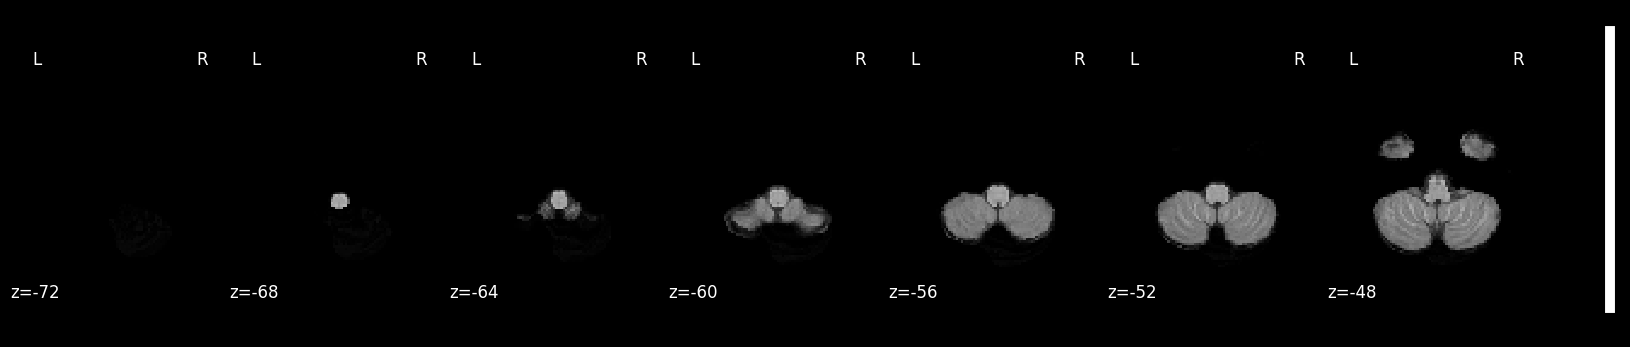

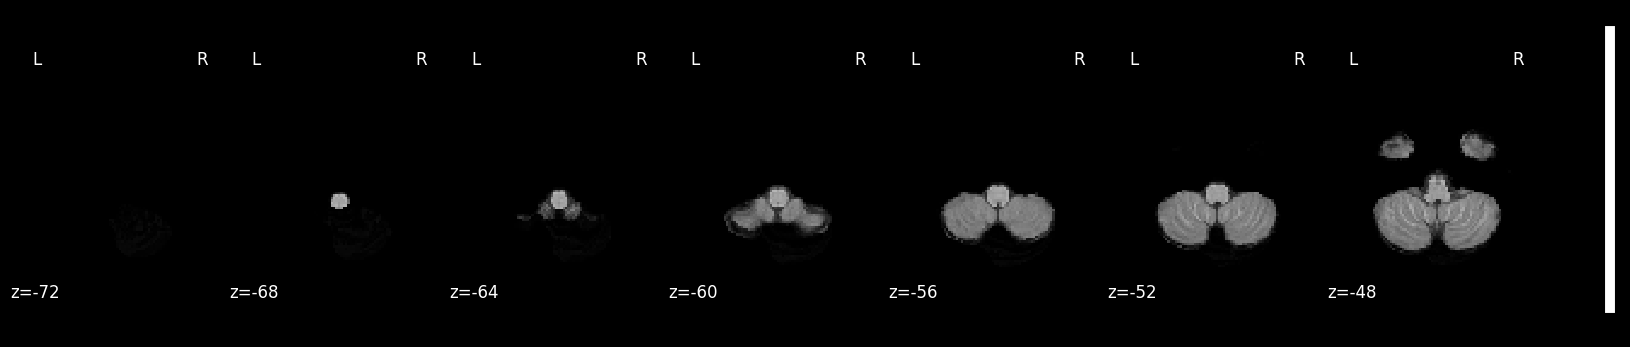

In [62]:
#mean(PD) - mean(HC)
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/baseline_PDvsHC_tfce_corrp_tstat1_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

#mean(HC) - mean(PD)
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/baseline_PDvsHC_tfce_corrp_tstat2_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

In [63]:
#mean(PD) - mean(HC)
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/baseline_PDvsHC_tfce_corrp_tstat1_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)
print("\n")

#mean(HC) - mean(PD)
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/baseline_PDvsHC_tfce_corrp_tstat2_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)

{}


{}


## 10b. Longitudinal Evaluation

#### 10bi - Control: BL vs FU
* Their result: "Atrophy clusters involved mainly WM and were more widespread in the frontal lobe. GM changes included paracentral lobule, precuneus, parietal superior gyrus, and anterior cingulum bilaterally, right frontal superior medial gyrus and left temporal middle gyrus, precentral gyrus, postcentral gyrus, middle cingulum, cuneus, and superior and middle occipital gyrus."
* My result: Mostly agree. We also found more widespread frontral lobe changes. We also found changes in all the areas they mentioned, with the exception of superior occipital gyrus and some lateralities. However, we also found many other regions with significant changes (listed below).

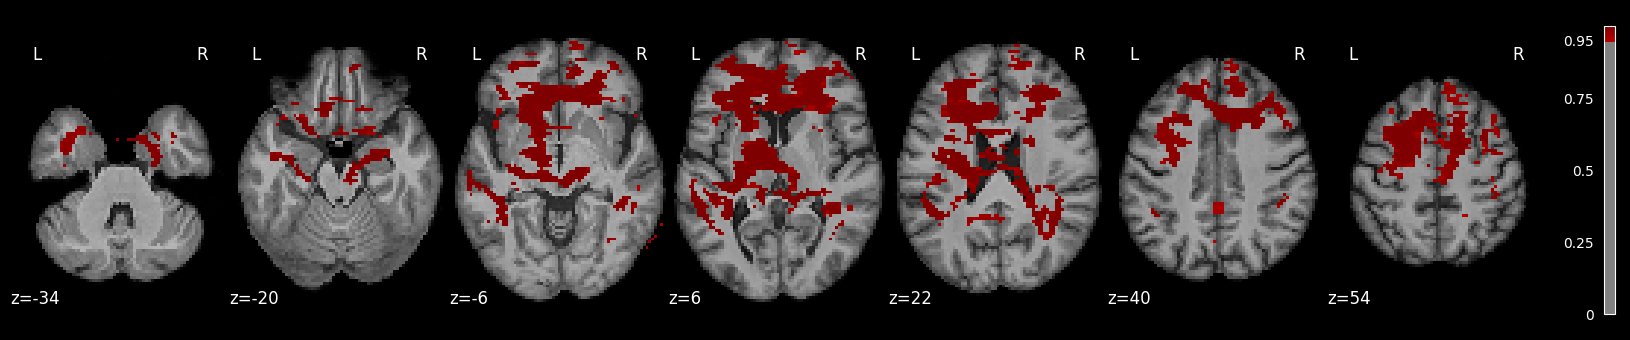

In [64]:
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/control_BLvsFU_tfce_corrp_tstat1_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

In [65]:
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/control_BLvsFU_tfce_corrp_tstat1_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)

{3.0: 'Frontal_Sup_2_L', 5.0: 'Frontal_Mid_2_L', 6.0: 'Frontal_Mid_2_R', 4.0: 'Frontal_Sup_2_R', 16.0: 'Supp_Motor_Area_R', 20.0: 'Frontal_Sup_Medial_R', 89.0: 'Temporal_Mid_L', 75.0: 'Caudate_L', 77.0: 'Putamen_L', 15.0: 'Supp_Motor_Area_L', 9.0: 'Frontal_Inf_Tri_L', 38.0: 'Cingulate_Mid_R', 19.0: 'Frontal_Sup_Medial_L', 33.0: 'Insula_L', 153.0: 'ACC_pre_L', 22.0: 'Frontal_Med_Orb_R', 1.0: 'Precentral_L', 2.0: 'Precentral_R', 79.0: 'Pallidum_L', 127.0: 'Thal_VL_L', 85.0: 'Temporal_Sup_L', 62.0: 'Postcentral_R', 23.0: 'Rectus_L', 93.0: 'Temporal_Inf_L', 44.0: 'ParaHippocampal_R', 41.0: 'Hippocampus_L', 155.0: 'ACC_sup_L', 74.0: 'Paracentral_Lobule_R', 154.0: 'ACC_pre_R', 42.0: 'Hippocampus_R', 76.0: 'Caudate_R', 11.0: 'Frontal_Inf_Orb_2_L', 67.0: 'SupraMarginal_L', 151.0: 'ACC_sub_L', 10.0: 'Frontal_Inf_Tri_R', 146.0: 'Thal_PuM_R', 37.0: 'Cingulate_Mid_L', 60.0: 'Fusiform_R', 12.0: 'Frontal_Inf_Orb_2_R', 72.0: 'Precuneus_R', 17.0: 'Olfactory_L', 21.0: 'Frontal_Med_Orb_L', 34.0: 'Insula

#### 10bii - Parkinsons: BL vs FU
* Their result: "GM involvement in PD patients was more widespread than in control subjects and included bilaterally the thalamus, caudate, putamen, superior and middle frontal gyrus, postcentral gyrus, anterior cingulum, insula, Rolandic operculum, Heschl gyrus, temporal middle and inferior gyrus, frontal inferior triangular gyrus, frontal inferior operculum, precuneus, frontal middle orbital gyrus, rectus gyrus and amygdala, right parahippocampal gyrus, olfactory gyrus and fusiform gyrus, and left precentral gyrus and posterior cingulum."
* My result: Mostly agree. GM changes also appear more widespread than in controls. We found changes in all the regions they listed, with the exception of the anterior cingulum. However the changes didn't necessarily replicate their laterality. We also found changes in multiple regions they didn't (see dictionary below for our list of regions).

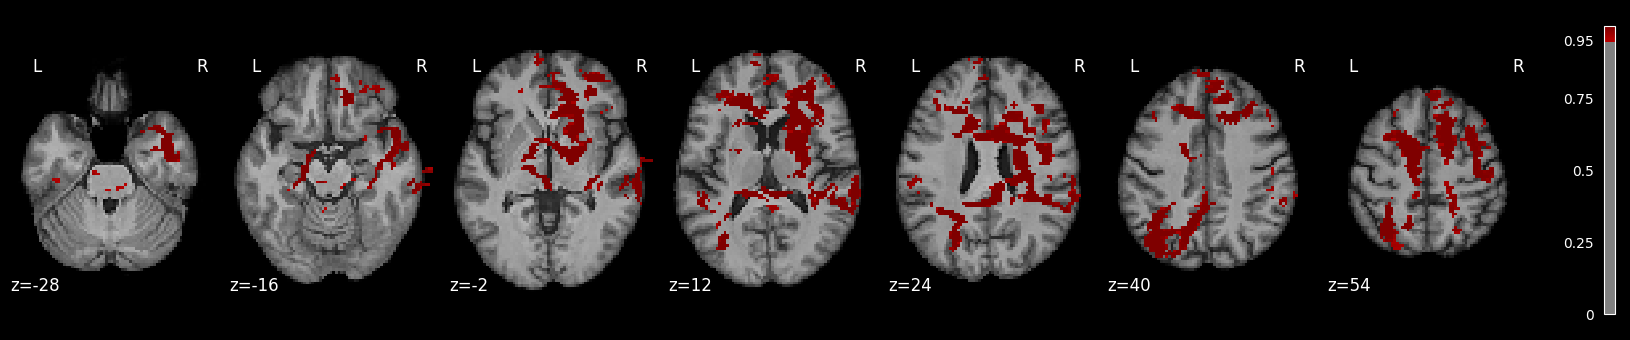

In [66]:
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/parkinsons_BLvsFU_tfce_corrp_tstat1_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

In [67]:
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/parkinsons_BLvsFU_tfce_corrp_tstat1_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)

{6.0: 'Frontal_Mid_2_R', 4.0: 'Frontal_Sup_2_R', 86.0: 'Temporal_Sup_R', 16.0: 'Supp_Motor_Area_R', 55.0: 'Occipital_Mid_L', 63.0: 'Parietal_Sup_L', 71.0: 'Precuneus_L', 90.0: 'Temporal_Mid_R', 78.0: 'Putamen_R', 19.0: 'Frontal_Sup_Medial_L', 69.0: 'Angular_L', 20.0: 'Frontal_Sup_Medial_R', 3.0: 'Frontal_Sup_2_L', 2.0: 'Precentral_R', 76.0: 'Caudate_R', 65.0: 'Parietal_Inf_L', 15.0: 'Supp_Motor_Area_L', 5.0: 'Frontal_Mid_2_L', 68.0: 'SupraMarginal_R', 38.0: 'Cingulate_Mid_R', 62.0: 'Postcentral_R', 88.0: 'Temporal_Pole_Sup_R', 53.0: 'Occipital_Sup_L', 10.0: 'Frontal_Inf_Tri_R', 94.0: 'Temporal_Inf_R', 37.0: 'Cingulate_Mid_L', 34.0: 'Insula_R', 39.0: 'Cingulate_Post_L', 80.0: 'Pallidum_R', 22.0: 'Frontal_Med_Orb_R', 92.0: 'Temporal_Pole_Mid_R', 67.0: 'SupraMarginal_L', 155.0: 'ACC_sup_L', 156.0: 'ACC_sup_R', 9.0: 'Frontal_Inf_Tri_L', 40.0: 'Cingulate_Post_R', 89.0: 'Temporal_Mid_L', 154.0: 'ACC_pre_R', 85.0: 'Temporal_Sup_L', 61.0: 'Postcentral_L', 42.0: 'Hippocampus_R', 73.0: 'Paracent

#### 10biii - PD vs Control
* Their result: "With respect to control subjects, during the follow-up period PD patients developed bilateral clusters of increased atrophy (i.e., WR values in PD patients were significantly lower than WR values in control subjects) in frontal superior and middle gyrus, anterior cingulum, caudate nucleus, and thalamus (Fig. 2). No other significant time (baseline vs. follow-up) x group (PD patients vs. control subjects) interaction was revealed."
* My result: Disagree. We found no significant changes in the WR values.

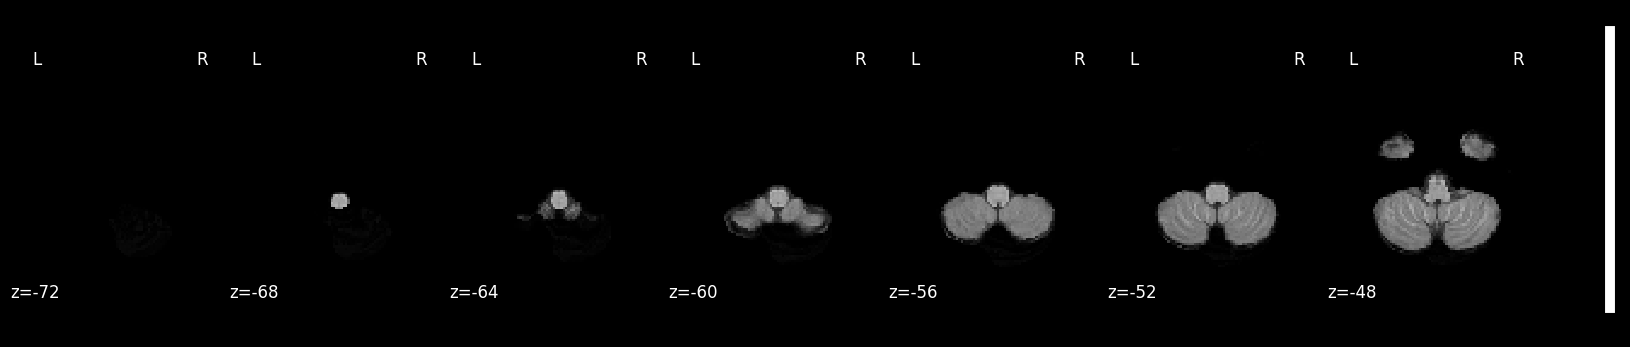

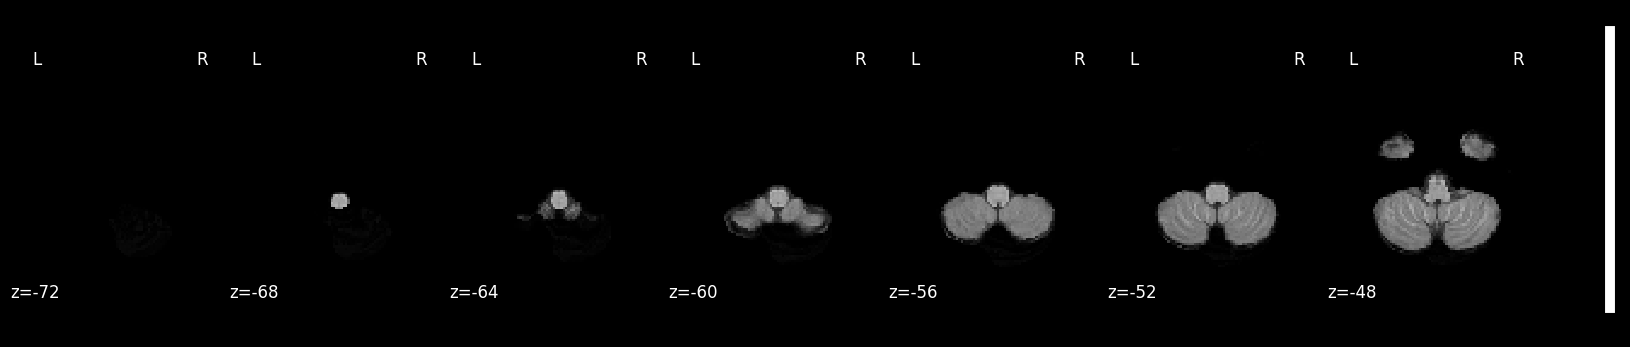

In [68]:
# mean(PD) - mean(HC)
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/longitudinal_PDvsHC_tfce_corrp_tstat1_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

# mean(HC) - mean(PD)
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/longitudinal_PDvsHC_tfce_corrp_tstat2_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

In [69]:
# mean(PD) - mean(HC)
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/longitudinal_PDvsHC_tfce_corrp_tstat1_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)
print("\n")

#mean(HC) - mean(PD)
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/longitudinal_PDvsHC_tfce_corrp_tstat2_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)

{}


{}


## 10c. Correlation Analysis

* Their result: "In PD patients, no significant correlation between warprates and motor or neuropsychological test scores or their average changes per year between baseline and follow-up were identified."
* My result: Agree. But note that there were many missing data columns, so we could not test all demographic data categories.

#### 10ci - Baseline

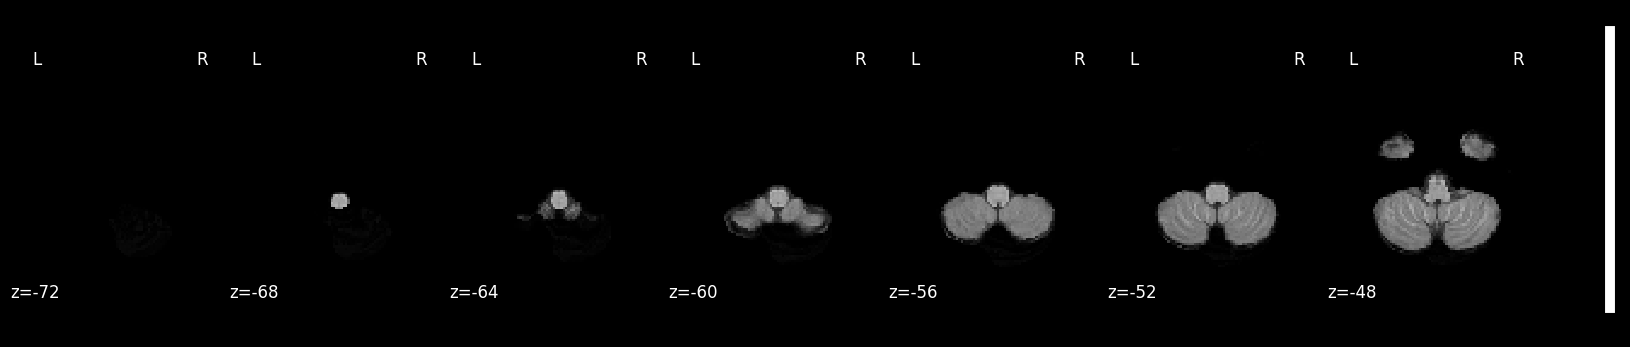

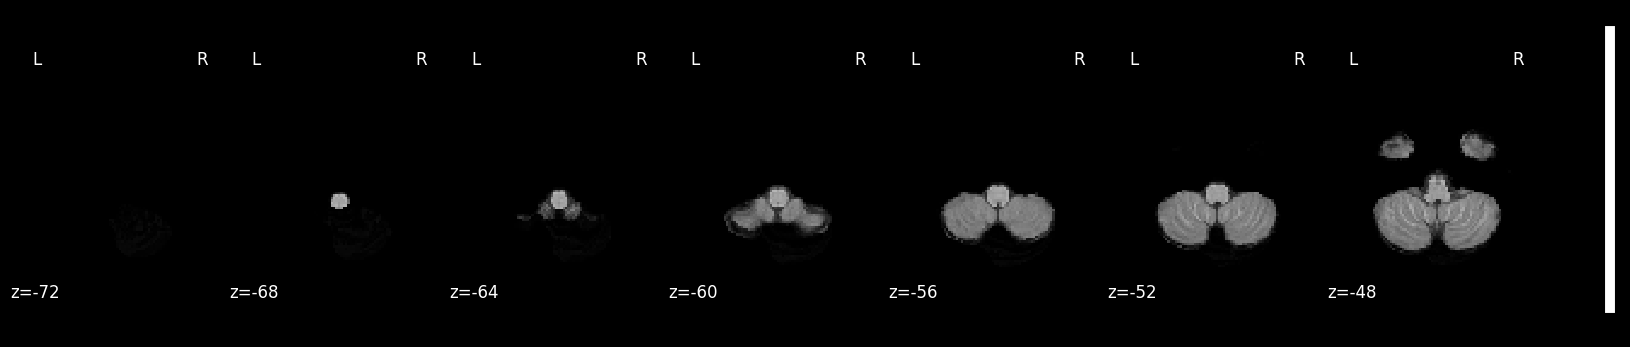

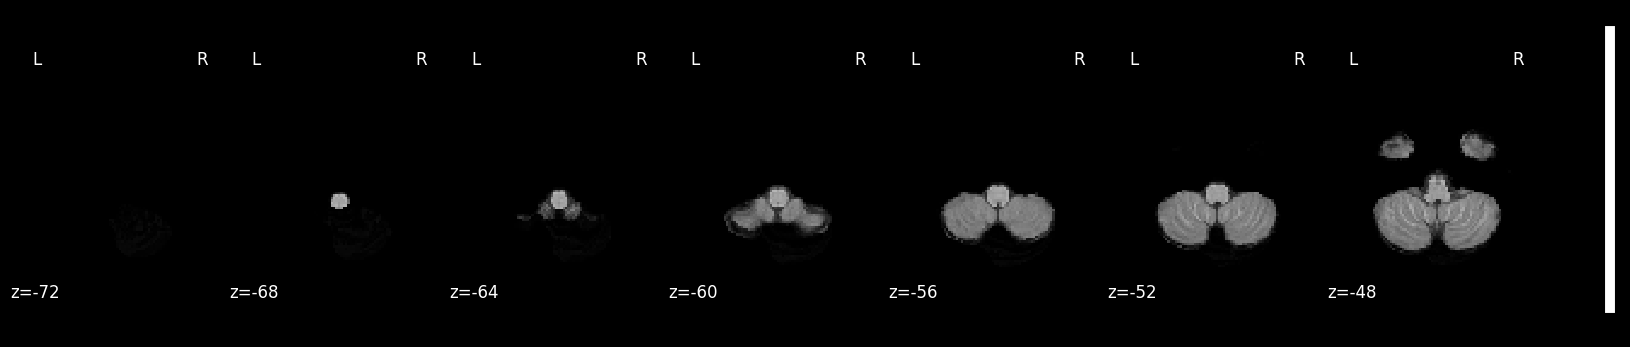

In [71]:
#NP3TOT
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/correlation_BL_tfce_corrp_tstat1_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

#NHY
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/correlation_BL_tfce_corrp_tstat2_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

#GDSTOT
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/correlation_BL_tfce_corrp_tstat3_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

In [72]:
#NP3TOT
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/correlation_BL_tfce_corrp_tstat1_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)
print

#NHY
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/correlation_BL_tfce_corrp_tstat2_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)
print("\n")

#GDSTOT
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/correlation_BL_tfce_corrp_tstat3_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)

{}
{}


{}


#### 10cii - Follow-up

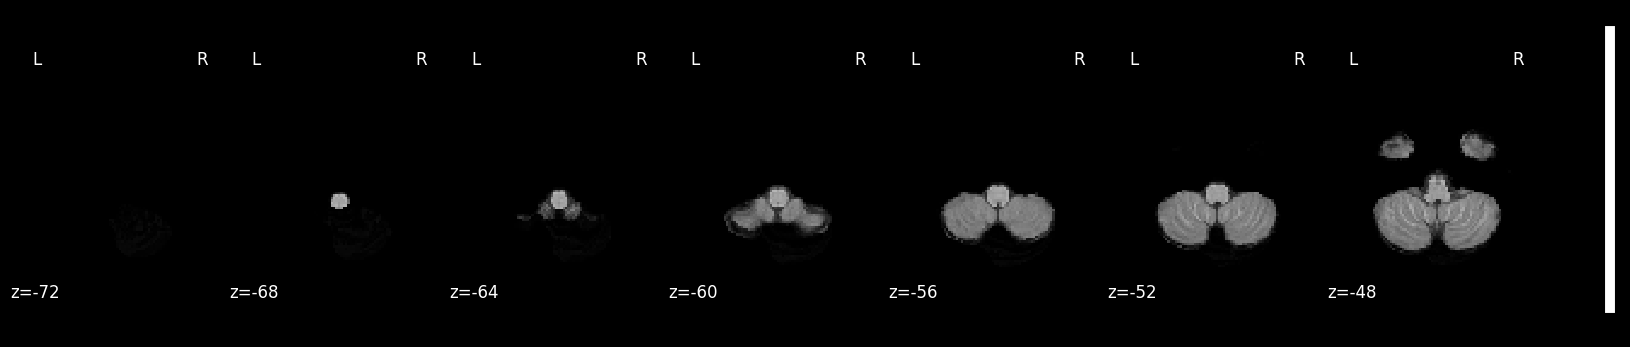

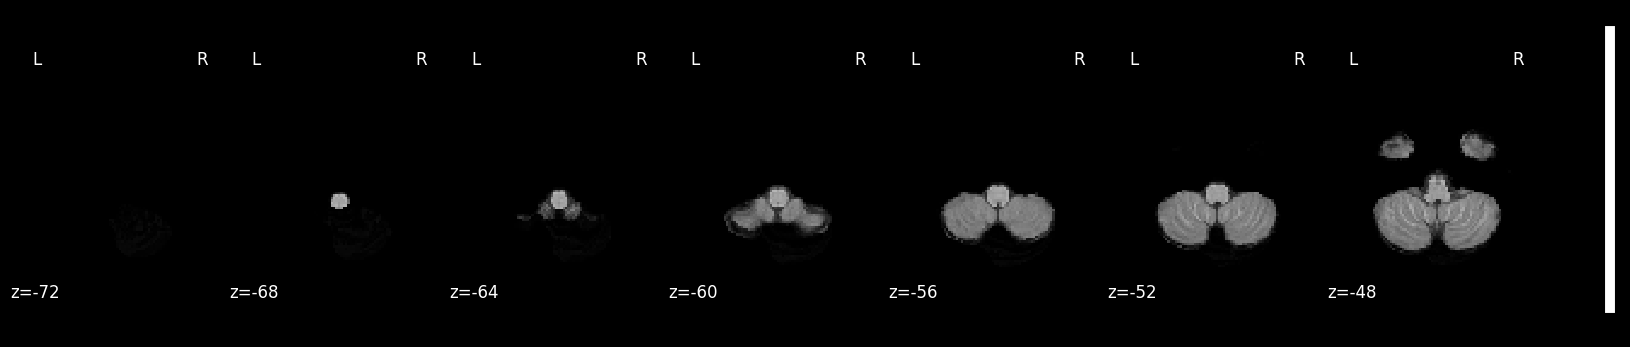

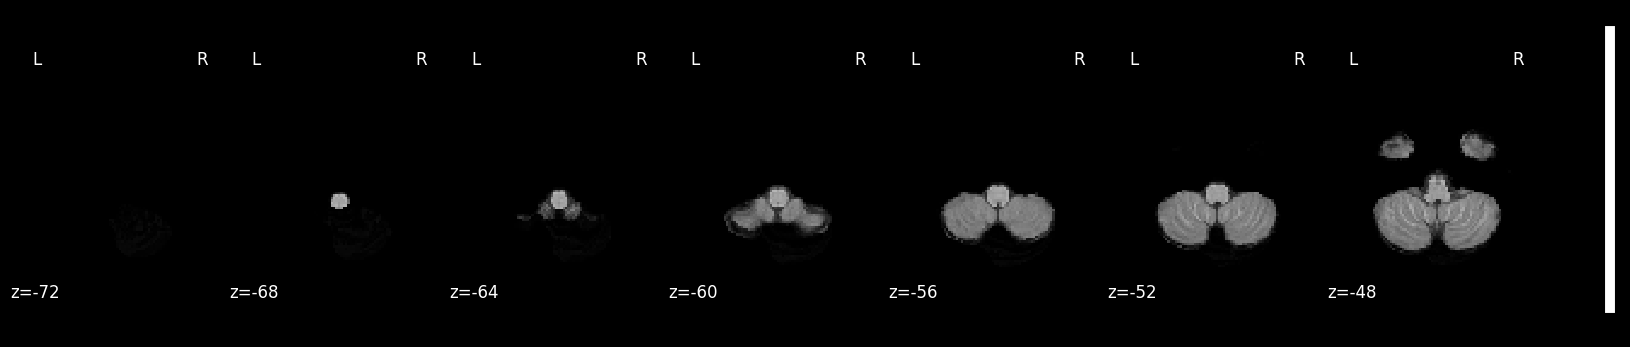

In [73]:
#MCATOT
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/correlation_fu_tfce_corrp_tstat1_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

#MMSETOT
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/correlation_fu_tfce_corrp_tstat2_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

#GDSTOT
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/correlation_fu_tfce_corrp_tstat3_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

In [74]:
#MCATOT
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/correlation_fu_tfce_corrp_tstat1_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)
print("\n")

#MMSETOT
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/correlation_fu_tfce_corrp_tstat2_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)
print("\n")

#GDSTOT
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/correlation_fu_tfce_corrp_tstat3_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)

{}


{}


{}


#### 10ciii - Delta (Yearly average change)

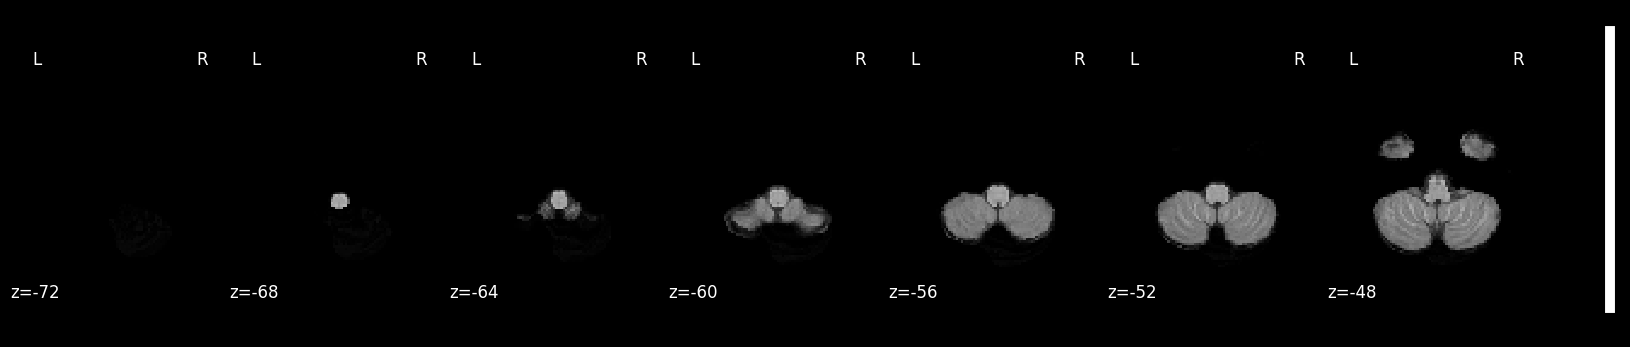

In [75]:
#GDSTOT
plotting.plot_stat_map(
    "./ANTs-derivatives/map2mni_nn_thresh/correlation_delta_tfce_corrp_tstat2_MNI_Warped.nii.gz",
    threshold=0.95,
    black_bg=True,
    cmap="jet",
    bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz", # GT registered to MNI
    display_mode="z"
)

In [76]:
#GDSTOT
overlap_labels = get_overlapping_labels_sorted(atlas_path,  "./ANTs-derivatives/map2mni_nn_thresh/correlation_delta_tfce_corrp_tstat2_MNI_Warped.nii.gz")
parts = map_labels_to_brain_parts(overlap_labels, aal3v1_label_to_brain_part)
print(parts)

{}


## 10d. Average Warp-Rates

In [77]:
def create_avg_T1(list_paths, avg_path):
    img = nib.load(list_paths[0])
    data = img.get_fdata()
    shape = data.shape
    sum_scan = np.zeros((shape[0],shape[1],shape[2]))
    for path in list_paths:
        scan = nib.load(path)
        scan_data = scan.get_fdata()
        sum_scan = sum_scan + scan_data
    avg_scan = sum_scan/len(list_paths)
    avg_scan_nifti = nib.Nifti1Image(avg_scan, scan.affine, scan.header)
    nib.save(avg_scan_nifti, avg_path)

#### 10di Average HC Warp-Rate

In [78]:
sorted_table = cohort.sort_values(by=["PATNO", "EVENT_ID"])
sorted_table = sorted_table.loc[sorted_table.COHORT == 2.0]
sorted_table = sorted_table.loc[sorted_table.EVENT_ID == "BL"] #so we have unique values in our IDs
control_list = sorted_table.PATNO.tolist()

dir_list = []
for i in control_list:
    path = find_paths_7b(int(i))
    if len(path) != 0:
        dir_list.append(path[0])    
    
create_avg_T1(dir_list, "./ANTs-derivatives/WR_avg_Control.nii.gz")

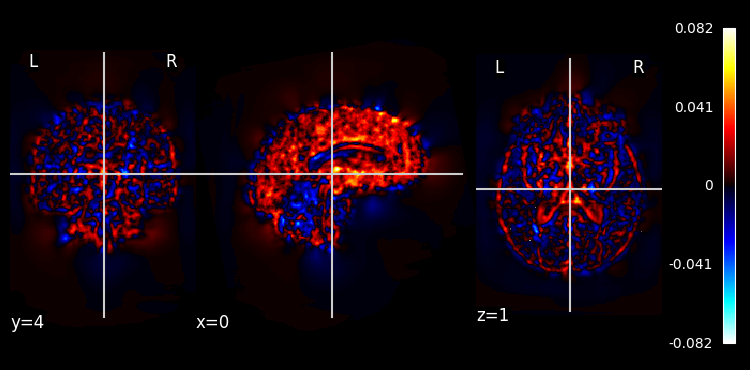

In [79]:
plotting.plot_stat_map("./ANTs-derivatives/WR_avg_Control.nii.gz", black_bg=True, bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz")

#### 10dii Average PD Warp-Rate

In [80]:
sorted_table = cohort.sort_values(by=["PATNO", "EVENT_ID"])
sorted_table = sorted_table.loc[sorted_table.COHORT == 1.0]
sorted_table = sorted_table.loc[sorted_table.EVENT_ID == "BL"] #so we have unique values in our IDs
park_list = sorted_table.PATNO.tolist()

dir_list = []
for i in park_list:
    path = find_paths_7b(int(i))
    if len(path) != 0:
        dir_list.append(path[0])  
    
create_avg_T1(dir_list, "./ANTs-derivatives/WR_avg_Parkinsons.nii.gz")

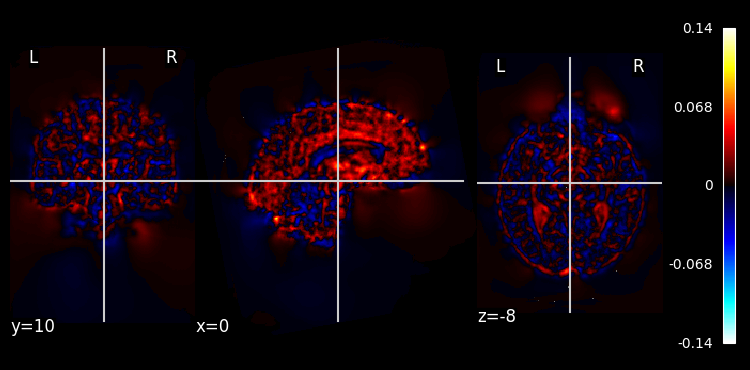

In [81]:
plotting.plot_stat_map("./ANTs-derivatives/WR_avg_Parkinsons.nii.gz", black_bg=True, bg_img="./ANTs-derivatives/GT/GT_template0_MNI_Warped.nii.gz")